In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# -----------------------------------------------------------
# ARQUIVOS DAS ESTAÇÕES
# -----------------------------------------------------------
stations = {
    "Caracarai": "caracarai_seca.csv",
    "Cucui": "cucui_seca.csv",
    "Moura": "moura_seca.csv",
    "Santa_Maria_do_Boiacu": "santa_maria_do_boiacu_seca.csv",
    "Serrinha": "serrinha_seca.csv"
}

subnet_config = {
    "Caracarai": {"filters": 64, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Cucui": {"filters": 64, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Moura": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Santa_Maria_do_Boiacu": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Serrinha": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
}

# -----------------------------------------------------------
# SUB-REDE
# -----------------------------------------------------------
def create_subnet(input_layer, filters, kernel_size, pool_size, dropout_rate):
    x = Conv1D(filters=filters, kernel_size=min(kernel_size, input_layer.shape[1]),
               activation='relu', padding='same')(input_layer)
    x = Conv1D(filters=filters * 2, kernel_size=min(kernel_size, input_layer.shape[1]),
               activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=min(pool_size, input_layer.shape[1]))(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=min(kernel_size, x.shape[1]),
               activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=min(pool_size, x.shape[1]))(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    return x

# -----------------------------------------------------------
# JANELAS DESLIZANTES
# -----------------------------------------------------------
def create_sliding_windows(series, window_size=10):
    X, Y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        Y.append(series[i+window_size])
    X = np.array(X).reshape(-1, window_size, 1)
    Y = np.array(Y).reshape(-1, 1)
    return X, Y

def process_data(file_path, window_size=10):
    df = pd.read_csv(file_path)
    series = df.iloc[:, -7].values / 100  # coluna do alvo

    X, Y = create_sliding_windows(series, window_size)

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X = scaler_x.fit_transform(X.reshape(-1, window_size)).reshape(-1, window_size, 1)
    Y = scaler_y.fit_transform(Y)

    return X, Y, scaler_y

station_data = {s: process_data(f) for s, f in stations.items()}

# -----------------------------------------------------------
# MODELO GLOBAL COM 5 SAÍDAS
# -----------------------------------------------------------
inputs = {}
subnets = {}
for station, config in subnet_config.items():
    inp = Input(shape=(10, 1), name=f"input_{station}")
    sub = create_subnet(inp, **config)
    inputs[station] = inp
    subnets[station] = sub

merged = concatenate(list(subnets.values()), name="merged_layer")
dense_1 = Dense(60, activation='relu', kernel_regularizer=l2(0.005))(merged)
dense_2 = Dense(30, activation='relu', kernel_regularizer=l2(0.005))(dense_1)

outputs = {station: Dense(1, name=f"output_{station}")(dense_2) for station in stations}



model = Model(inputs=list(inputs.values()), outputs=list(outputs.values()))
losses = {f"output_{st}": "mse" for st in stations}
metrics = {f"output_{st}": ["mae"] for st in stations}
model.compile(optimizer=Adam(0.001), loss=losses, metrics=metrics)

# -----------------------------------------------------------
# TREINO
# -----------------------------------------------------------
X_all = {f"input_{st}": station_data[st][0] for st in stations}
Y_all = {f"output_{st}": station_data[st][1] for st in stations}

history = model.fit(
    X_all,
    Y_all,
    epochs=1000,
    validation_split=0.2,  # agora automático, mantém toda a série
    verbose=1
)

# -----------------------------------------------------------
# PREVISÃO GLOBAL
# -----------------------------------------------------------
for station in stations:
    X_test, Y_test, scaler_y = station_data[station]
    X_inputs = {f"input_{s}": station_data[s][0] for s in stations}
    idx = list(stations.keys()).index(station)
    preds = model.predict(X_inputs)[idx]
    preds_rescaled = scaler_y.inverse_transform(preds)
    real_rescaled  = scaler_y.inverse_transform(Y_test)
    df_out = pd.DataFrame({"Observed": real_rescaled.flatten(),
                           "Predicted": preds_rescaled.flatten()})
    df_out.to_csv(f"{station}_previsoes_seca.csv", index=False)
    print(f"Gerado: {station}_previsoes_seca.csv")


Epoch 1/1000


/home/carlos/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_Caracarai', 'input_Cucui', 'input_Moura', 'input_Santa_Maria_do_Boiacu', 'input_Serrinha']. Received: the structure of inputs={'input_Caracarai': '*', 'input_Cucui': '*', 'input_Moura': '*', 'input_Santa_Maria_do_Boiacu': '*', 'input_Serrinha': '*'}
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 1.4937 - output_Caracarai_loss: 0.1753 - output_Caracarai_mae: 0.2995 - output_Cucui_loss: 0.1375 - output_Cucui_mae: 0.2804 - output_Moura_loss: 0.1857 - output_Moura_mae: 0.3031 - output_Santa_Maria_do_Boiacu_loss: 0.1482 - output_Santa_Maria_do_Boiacu_mae: 0.2540 - output_Serrinha_loss: 0.1352 - output_Serrinha_mae: 0.2842 - val_loss: 1.3525 - val_output_Caracarai_loss: 0.6151 - val_output_Caracarai_mae: 0.5924 - val_output_Cucui_loss: 0.2226 - val_output_Cucui_mae: 0.4616 - val_output_Moura_loss: 0.0108 - val_output_Moura_mae: 0.0736 - val_output_Santa_Maria_do_Boiacu_loss: 0.0064 - val_output_Santa_Maria_do_Boiacu_mae: 0.0629 - val_output_Serrinha_loss: 0.0213 - val_output_Serrinha_mae: 0.1571
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8295 - output_Caracarai_loss: 0.0744 - output_Caracarai_mae: 0.1663 - output_Cucui_loss: 0.0217 - output_Cucui_mae: 0.1049 - output_Moura_loss: 0.0214 - output_Moura_mae: 0.1163 - outpu

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1508 - output_Caracarai_loss: 0.0064 - output_Caracarai_mae: 0.0436 - output_Cucui_loss: 0.0044 - output_Cucui_mae: 0.0472 - output_Moura_loss: 0.0043 - output_Moura_mae: 0.0466 - output_Santa_Maria_do_Boiacu_loss: 0.0032 - output_Santa_Maria_do_Boiacu_mae: 0.0374 - output_Serrinha_loss: 0.0048 - output_Serrinha_mae: 0.0540 - val_loss: 0.2209 - val_output_Caracarai_loss: 0.0348 - val_output_Caracarai_mae: 0.1041 - val_output_Cucui_loss: 0.0303 - val_output_Cucui_mae: 0.1719 - val_output_Moura_loss: 0.0051 - val_output_Moura_mae: 0.0589 - val_output_Santa_Maria_do_Boiacu_loss: 0.0016 - val_output_Santa_Maria_do_Boiacu_mae: 0.0297 - val_output_Serrinha_loss: 0.0399 - val_output_Serrinha_mae: 0.2046
Epoch 22/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1394 - output_Caracarai_loss: 0.0055 - output_Caracarai_mae: 0.0390 - output_Cucui_loss: 0.0044 - output_Cucui_mae: 0.0472 - output_Moura_loss: 0.0038 - output_Moura_mae: 0.0453 - outp

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0602 - output_Caracarai_loss: 0.0037 - output_Caracarai_mae: 0.0331 - output_Cucui_loss: 0.0033 - output_Cucui_mae: 0.0431 - output_Moura_loss: 0.0035 - output_Moura_mae: 0.0415 - output_Santa_Maria_do_Boiacu_loss: 0.0022 - output_Santa_Maria_do_Boiacu_mae: 0.0326 - output_Serrinha_loss: 0.0032 - output_Serrinha_mae: 0.0432 - val_loss: 0.0969 - val_output_Caracarai_loss: 0.0080 - val_output_Caracarai_mae: 0.0574 - val_output_Cucui_loss: 0.0114 - val_output_Cucui_mae: 0.1091 - val_output_Moura_loss: 0.0093 - val_output_Moura_mae: 0.0670 - val_output_Santa_Maria_do_Boiacu_loss: 0.0090 - val_output_Santa_Maria_do_Boiacu_mae: 0.0991 - val_output_Serrinha_loss: 0.0161 - val_output_Serrinha_mae: 0.1347
Epoch 42/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0566 - output_Caracarai_loss: 0.0022 - output_Caracarai_mae: 0.0289 - output_Cucui_loss: 0.0030 - output_Cucui_mae: 0.0429 - output_Moura_loss: 0.0032 - output_Moura_mae: 0.0416 - outp

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0339 - output_Caracarai_loss: 0.0016 - output_Caracarai_mae: 0.0251 - output_Cucui_loss: 0.0030 - output_Cucui_mae: 0.0395 - output_Moura_loss: 0.0025 - output_Moura_mae: 0.0367 - output_Santa_Maria_do_Boiacu_loss: 0.0018 - output_Santa_Maria_do_Boiacu_mae: 0.0288 - output_Serrinha_loss: 0.0025 - output_Serrinha_mae: 0.0388 - val_loss: 0.0913 - val_output_Caracarai_loss: 0.0108 - val_output_Caracarai_mae: 0.0565 - val_output_Cucui_loss: 0.0239 - val_output_Cucui_mae: 0.1514 - val_output_Moura_loss: 0.0036 - val_output_Moura_mae: 0.0498 - val_output_Santa_Maria_do_Boiacu_loss: 0.0029 - val_output_Santa_Maria_do_Boiacu_mae: 0.0305 - val_output_Serrinha_loss: 0.0306 - val_output_Serrinha_mae: 0.1802
Epoch 62/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0338 - output_Caracarai_loss: 0.0015 - output_Caracarai_mae: 0.0222 - output_Cucui_loss: 0.0029 - output_Cucui_mae: 0.0392 - output_Moura_loss: 0.0026 - output_Moura_mae: 0.0347 - outp

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0262 - output_Caracarai_loss: 0.0017 - output_Caracarai_mae: 0.0258 - output_Cucui_loss: 0.0028 - output_Cucui_mae: 0.0388 - output_Moura_loss: 0.0028 - output_Moura_mae: 0.0381 - output_Santa_Maria_do_Boiacu_loss: 0.0017 - output_Santa_Maria_do_Boiacu_mae: 0.0267 - output_Serrinha_loss: 0.0030 - output_Serrinha_mae: 0.0414 - val_loss: 0.0686 - val_output_Caracarai_loss: 0.0133 - val_output_Caracarai_mae: 0.0677 - val_output_Cucui_loss: 0.0160 - val_output_Cucui_mae: 0.1233 - val_output_Moura_loss: 0.0075 - val_output_Moura_mae: 0.0594 - val_output_Santa_Maria_do_Boiacu_loss: 0.0023 - val_output_Santa_Maria_do_Boiacu_mae: 0.0482 - val_output_Serrinha_loss: 0.0196 - val_output_Serrinha_mae: 0.1455
Epoch 82/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0238 - output_Caracarai_loss: 0.0018 - output_Caracarai_mae: 0.0264 - output_Cucui_loss: 0.0024 - output_Cucui_mae: 0.0364 - output_Moura_loss: 0.0019 - output_Moura_mae: 0.0311 - outp

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0204 - output_Caracarai_loss: 0.0021 - output_Caracarai_mae: 0.0261 - output_Cucui_loss: 0.0021 - output_Cucui_mae: 0.0344 - output_Moura_loss: 0.0022 - output_Moura_mae: 0.0316 - output_Santa_Maria_do_Boiacu_loss: 0.0017 - output_Santa_Maria_do_Boiacu_mae: 0.0266 - output_Serrinha_loss: 0.0021 - output_Serrinha_mae: 0.0353 - val_loss: 0.0484 - val_output_Caracarai_loss: 0.0157 - val_output_Caracarai_mae: 0.0660 - val_output_Cucui_loss: 0.0072 - val_output_Cucui_mae: 0.0824 - val_output_Moura_loss: 0.0049 - val_output_Moura_mae: 0.0516 - val_output_Santa_Maria_do_Boiacu_loss: 0.0023 - val_output_Santa_Maria_do_Boiacu_mae: 0.0474 - val_output_Serrinha_loss: 0.0138 - val_output_Serrinha_mae: 0.1223
Epoch 102/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189 - output_Caracarai_loss: 0.0020 - output_Caracarai_mae: 0.0253 - output_Cucui_loss: 0.0022 - output_Cucui_mae: 0.0330 - output_Moura_loss: 0.0017 - output_Moura_mae: 0.0289 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0160 - output_Caracarai_loss: 0.0015 - output_Caracarai_mae: 0.0247 - output_Cucui_loss: 0.0019 - output_Cucui_mae: 0.0324 - output_Moura_loss: 0.0016 - output_Moura_mae: 0.0303 - output_Santa_Maria_do_Boiacu_loss: 0.0012 - output_Santa_Maria_do_Boiacu_mae: 0.0244 - output_Serrinha_loss: 0.0019 - output_Serrinha_mae: 0.0345 - val_loss: 0.0473 - val_output_Caracarai_loss: 0.0078 - val_output_Caracarai_mae: 0.0498 - val_output_Cucui_loss: 0.0090 - val_output_Cucui_mae: 0.0930 - val_output_Moura_loss: 0.0040 - val_output_Moura_mae: 0.0472 - val_output_Santa_Maria_do_Boiacu_loss: 0.0022 - val_output_Santa_Maria_do_Boiacu_mae: 0.0480 - val_output_Serrinha_loss: 0.0173 - val_output_Serrinha_mae: 0.1361
Epoch 122/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167 - output_Caracarai_loss: 0.0015 - output_Caracarai_mae: 0.0236 - output_Cucui_loss: 0.0023 - output_Cucui_mae: 0.0322 - output_Moura_loss: 0.0020 - output_Moura_mae: 0.0308 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0141 - output_Caracarai_loss: 0.0016 - output_Caracarai_mae: 0.0243 - output_Cucui_loss: 0.0017 - output_Cucui_mae: 0.0291 - output_Moura_loss: 0.0016 - output_Moura_mae: 0.0278 - output_Santa_Maria_do_Boiacu_loss: 9.9759e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0234 - output_Serrinha_loss: 0.0016 - output_Serrinha_mae: 0.0299 - val_loss: 0.0378 - val_output_Caracarai_loss: 0.0063 - val_output_Caracarai_mae: 0.0466 - val_output_Cucui_loss: 0.0050 - val_output_Cucui_mae: 0.0680 - val_output_Moura_loss: 0.0087 - val_output_Moura_mae: 0.0709 - val_output_Santa_Maria_do_Boiacu_loss: 0.0024 - val_output_Santa_Maria_do_Boiacu_mae: 0.0520 - val_output_Serrinha_loss: 0.0112 - val_output_Serrinha_mae: 0.1078
Epoch 142/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - output_Caracarai_loss: 0.0016 - output_Caracarai_mae: 0.0228 - output_Cucui_loss: 0.0018 - output_Cucui_mae: 0.0277 - output_Moura_loss: 0.0019 - output_Moura_mae: 0.0312 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0124 - output_Caracarai_loss: 0.0013 - output_Caracarai_mae: 0.0216 - output_Cucui_loss: 0.0015 - output_Cucui_mae: 0.0272 - output_Moura_loss: 0.0015 - output_Moura_mae: 0.0280 - output_Santa_Maria_do_Boiacu_loss: 8.1295e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0195 - output_Serrinha_loss: 0.0016 - output_Serrinha_mae: 0.0310 - val_loss: 0.0384 - val_output_Caracarai_loss: 0.0034 - val_output_Caracarai_mae: 0.0399 - val_output_Cucui_loss: 0.0053 - val_output_Cucui_mae: 0.0736 - val_output_Moura_loss: 0.0106 - val_output_Moura_mae: 0.0727 - val_output_Santa_Maria_do_Boiacu_loss: 0.0021 - val_output_Santa_Maria_do_Boiacu_mae: 0.0478 - val_output_Serrinha_loss: 0.0119 - val_output_Serrinha_mae: 0.1144
Epoch 162/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0125 - output_Caracarai_loss: 0.0016 - output_Caracarai_mae: 0.0237 - output_Cucui_loss: 0.0014 - output_Cucui_mae: 0.0283 - output_Moura_loss: 0.0014 - output_Moura_mae: 0.0264 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0116 - output_Caracarai_loss: 8.2672e-04 - output_Caracarai_mae: 0.0183 - output_Cucui_loss: 0.0020 - output_Cucui_mae: 0.0293 - output_Moura_loss: 0.0014 - output_Moura_mae: 0.0259 - output_Santa_Maria_do_Boiacu_loss: 9.5644e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0217 - output_Serrinha_loss: 0.0016 - output_Serrinha_mae: 0.0313 - val_loss: 0.0391 - val_output_Caracarai_loss: 0.0069 - val_output_Caracarai_mae: 0.0486 - val_output_Cucui_loss: 0.0033 - val_output_Cucui_mae: 0.0584 - val_output_Moura_loss: 0.0126 - val_output_Moura_mae: 0.0805 - val_output_Santa_Maria_do_Boiacu_loss: 0.0036 - val_output_Santa_Maria_do_Boiacu_mae: 0.0643 - val_output_Serrinha_loss: 0.0107 - val_output_Serrinha_mae: 0.1084
Epoch 182/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0122 - output_Caracarai_loss: 9.2377e-04 - output_Caracarai_mae: 0.0195 - output_Cucui_loss: 0.0018 - output_Cucui_mae: 0.0295 - output_Moura_loss: 0.0019 - output_Moura_mae: 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0102 - output_Caracarai_loss: 7.8238e-04 - output_Caracarai_mae: 0.0183 - output_Cucui_loss: 0.0013 - output_Cucui_mae: 0.0272 - output_Moura_loss: 0.0013 - output_Moura_mae: 0.0265 - output_Santa_Maria_do_Boiacu_loss: 9.1855e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0196 - output_Serrinha_loss: 0.0015 - output_Serrinha_mae: 0.0287 - val_loss: 0.0488 - val_output_Caracarai_loss: 0.0119 - val_output_Caracarai_mae: 0.0687 - val_output_Cucui_loss: 0.0078 - val_output_Cucui_mae: 0.0901 - val_output_Moura_loss: 0.0116 - val_output_Moura_mae: 0.0729 - val_output_Santa_Maria_do_Boiacu_loss: 0.0027 - val_output_Santa_Maria_do_Boiacu_mae: 0.0555 - val_output_Serrinha_loss: 0.0144 - val_output_Serrinha_mae: 0.1268
Epoch 202/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0112 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0205 - output_Cucui_loss: 0.0018 - output_Cucui_mae: 0.0284 - output_Moura_loss: 0.0015 - output_Moura_mae: 0.02

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0208 - output_Cucui_loss: 0.0014 - output_Cucui_mae: 0.0264 - output_Moura_loss: 0.0014 - output_Moura_mae: 0.0264 - output_Santa_Maria_do_Boiacu_loss: 0.0012 - output_Santa_Maria_do_Boiacu_mae: 0.0234 - output_Serrinha_loss: 0.0017 - output_Serrinha_mae: 0.0323 - val_loss: 0.0400 - val_output_Caracarai_loss: 0.0126 - val_output_Caracarai_mae: 0.0633 - val_output_Cucui_loss: 0.0051 - val_output_Cucui_mae: 0.0735 - val_output_Moura_loss: 0.0077 - val_output_Moura_mae: 0.0652 - val_output_Santa_Maria_do_Boiacu_loss: 0.0016 - val_output_Santa_Maria_do_Boiacu_mae: 0.0384 - val_output_Serrinha_loss: 0.0134 - val_output_Serrinha_mae: 0.1192
Epoch 222/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0093 - output_Caracarai_loss: 6.8261e-04 - output_Caracarai_mae: 0.0166 - output_Cucui_loss: 0.0012 - output_Cucui_mae: 0.0243 - output_Moura_loss: 0.0013 - output_Moura_mae: 0.0268 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0123 - output_Caracarai_loss: 0.0014 - output_Caracarai_mae: 0.0216 - output_Cucui_loss: 0.0023 - output_Cucui_mae: 0.0328 - output_Moura_loss: 0.0017 - output_Moura_mae: 0.0292 - output_Santa_Maria_do_Boiacu_loss: 8.9212e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0217 - output_Serrinha_loss: 0.0022 - output_Serrinha_mae: 0.0340 - val_loss: 0.0497 - val_output_Caracarai_loss: 0.0066 - val_output_Caracarai_mae: 0.0457 - val_output_Cucui_loss: 0.0098 - val_output_Cucui_mae: 0.1023 - val_output_Moura_loss: 0.0119 - val_output_Moura_mae: 0.0740 - val_output_Santa_Maria_do_Boiacu_loss: 0.0043 - val_output_Santa_Maria_do_Boiacu_mae: 0.0710 - val_output_Serrinha_loss: 0.0145 - val_output_Serrinha_mae: 0.1271
Epoch 242/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0094 - output_Caracarai_loss: 8.4974e-04 - output_Caracarai_mae: 0.0178 - output_Cucui_loss: 0.0016 - output_Cucui_mae: 0.0292 - output_Moura_loss: 0.0010 - output_Moura_mae: 0.02

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0098 - output_Caracarai_loss: 0.0014 - output_Caracarai_mae: 0.0236 - output_Cucui_loss: 0.0013 - output_Cucui_mae: 0.0282 - output_Moura_loss: 0.0012 - output_Moura_mae: 0.0257 - output_Santa_Maria_do_Boiacu_loss: 9.6108e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0220 - output_Serrinha_loss: 0.0013 - output_Serrinha_mae: 0.0277 - val_loss: 0.0374 - val_output_Caracarai_loss: 0.0115 - val_output_Caracarai_mae: 0.0561 - val_output_Cucui_loss: 0.0049 - val_output_Cucui_mae: 0.0713 - val_output_Moura_loss: 0.0051 - val_output_Moura_mae: 0.0504 - val_output_Santa_Maria_do_Boiacu_loss: 0.0026 - val_output_Santa_Maria_do_Boiacu_mae: 0.0486 - val_output_Serrinha_loss: 0.0133 - val_output_Serrinha_mae: 0.1206
Epoch 262/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0092 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0212 - output_Cucui_loss: 0.0012 - output_Cucui_mae: 0.0247 - output_Moura_loss: 0.0013 - output_Moura_mae: 0.0248 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0086 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0207 - output_Cucui_loss: 0.0011 - output_Cucui_mae: 0.0244 - output_Moura_loss: 0.0011 - output_Moura_mae: 0.0240 - output_Santa_Maria_do_Boiacu_loss: 8.3451e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0200 - output_Serrinha_loss: 0.0012 - output_Serrinha_mae: 0.0282 - val_loss: 0.0467 - val_output_Caracarai_loss: 0.0173 - val_output_Caracarai_mae: 0.0723 - val_output_Cucui_loss: 0.0041 - val_output_Cucui_mae: 0.0646 - val_output_Moura_loss: 0.0113 - val_output_Moura_mae: 0.0732 - val_output_Santa_Maria_do_Boiacu_loss: 0.0045 - val_output_Santa_Maria_do_Boiacu_mae: 0.0718 - val_output_Serrinha_loss: 0.0133 - val_output_Serrinha_mae: 0.1202
Epoch 282/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0098 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0212 - output_Cucui_loss: 0.0016 - output_Cucui_mae: 0.0289 - output_Moura_loss: 0.0012 - output_Moura_mae: 0.0264 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0080 - output_Caracarai_loss: 8.9518e-04 - output_Caracarai_mae: 0.0188 - output_Cucui_loss: 0.0011 - output_Cucui_mae: 0.0224 - output_Moura_loss: 8.8542e-04 - output_Moura_mae: 0.0213 - output_Santa_Maria_do_Boiacu_loss: 7.3992e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0186 - output_Serrinha_loss: 0.0013 - output_Serrinha_mae: 0.0283 - val_loss: 0.0464 - val_output_Caracarai_loss: 0.0096 - val_output_Caracarai_mae: 0.0541 - val_output_Cucui_loss: 0.0064 - val_output_Cucui_mae: 0.0836 - val_output_Moura_loss: 0.0137 - val_output_Moura_mae: 0.0820 - val_output_Santa_Maria_do_Boiacu_loss: 0.0041 - val_output_Santa_Maria_do_Boiacu_mae: 0.0683 - val_output_Serrinha_loss: 0.0123 - val_output_Serrinha_mae: 0.1175
Epoch 302/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082 - output_Caracarai_loss: 6.9575e-04 - output_Caracarai_mae: 0.0166 - output_Cucui_loss: 0.0013 - output_Cucui_mae: 0.0233 - output_Moura_loss: 0.0011 - output_Moura_m

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095 - output_Caracarai_loss: 8.6351e-04 - output_Caracarai_mae: 0.0187 - output_Cucui_loss: 0.0018 - output_Cucui_mae: 0.0274 - output_Moura_loss: 0.0016 - output_Moura_mae: 0.0271 - output_Santa_Maria_do_Boiacu_loss: 7.7679e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0193 - output_Serrinha_loss: 0.0016 - output_Serrinha_mae: 0.0291 - val_loss: 0.0474 - val_output_Caracarai_loss: 0.0163 - val_output_Caracarai_mae: 0.0696 - val_output_Cucui_loss: 0.0067 - val_output_Cucui_mae: 0.0838 - val_output_Moura_loss: 0.0050 - val_output_Moura_mae: 0.0496 - val_output_Santa_Maria_do_Boiacu_loss: 0.0037 - val_output_Santa_Maria_do_Boiacu_mae: 0.0649 - val_output_Serrinha_loss: 0.0168 - val_output_Serrinha_mae: 0.1351
Epoch 322/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0207 - output_Cucui_loss: 9.7724e-04 - output_Cucui_mae: 0.0227 - output_Moura_loss: 0.0017 - output_Moura_mae: 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0078 - output_Caracarai_loss: 8.6242e-04 - output_Caracarai_mae: 0.0196 - output_Cucui_loss: 0.0012 - output_Cucui_mae: 0.0260 - output_Moura_loss: 0.0011 - output_Moura_mae: 0.0247 - output_Santa_Maria_do_Boiacu_loss: 6.6787e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0194 - output_Serrinha_loss: 0.0012 - output_Serrinha_mae: 0.0274 - val_loss: 0.0417 - val_output_Caracarai_loss: 0.0129 - val_output_Caracarai_mae: 0.0655 - val_output_Cucui_loss: 0.0019 - val_output_Cucui_mae: 0.0428 - val_output_Moura_loss: 0.0182 - val_output_Moura_mae: 0.0897 - val_output_Santa_Maria_do_Boiacu_loss: 0.0064 - val_output_Santa_Maria_do_Boiacu_mae: 0.0856 - val_output_Serrinha_loss: 0.0074 - val_output_Serrinha_mae: 0.0877
Epoch 342/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0090 - output_Caracarai_loss: 0.0015 - output_Caracarai_mae: 0.0228 - output_Cucui_loss: 0.0014 - output_Cucui_mae: 0.0262 - output_Moura_loss: 0.0013 - output_Moura_mae: 0.02

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082 - output_Caracarai_loss: 7.3173e-04 - output_Caracarai_mae: 0.0174 - output_Cucui_loss: 0.0014 - output_Cucui_mae: 0.0271 - output_Moura_loss: 0.0012 - output_Moura_mae: 0.0254 - output_Santa_Maria_do_Boiacu_loss: 8.8147e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0200 - output_Serrinha_loss: 0.0012 - output_Serrinha_mae: 0.0261 - val_loss: 0.0405 - val_output_Caracarai_loss: 0.0080 - val_output_Caracarai_mae: 0.0497 - val_output_Cucui_loss: 0.0031 - val_output_Cucui_mae: 0.0565 - val_output_Moura_loss: 0.0188 - val_output_Moura_mae: 0.1008 - val_output_Santa_Maria_do_Boiacu_loss: 0.0048 - val_output_Santa_Maria_do_Boiacu_mae: 0.0741 - val_output_Serrinha_loss: 0.0075 - val_output_Serrinha_mae: 0.0870
Epoch 362/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - output_Caracarai_loss: 9.3755e-04 - output_Caracarai_mae: 0.0183 - output_Cucui_loss: 0.0010 - output_Cucui_mae: 0.0247 - output_Moura_loss: 0.0011 - output_Moura_mae: 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0072 - output_Caracarai_loss: 9.1948e-04 - output_Caracarai_mae: 0.0179 - output_Cucui_loss: 0.0012 - output_Cucui_mae: 0.0231 - output_Moura_loss: 8.6949e-04 - output_Moura_mae: 0.0214 - output_Santa_Maria_do_Boiacu_loss: 6.9925e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0177 - output_Serrinha_loss: 9.9088e-04 - output_Serrinha_mae: 0.0232 - val_loss: 0.0398 - val_output_Caracarai_loss: 0.0047 - val_output_Caracarai_mae: 0.0476 - val_output_Cucui_loss: 0.0024 - val_output_Cucui_mae: 0.0496 - val_output_Moura_loss: 0.0189 - val_output_Moura_mae: 0.0995 - val_output_Santa_Maria_do_Boiacu_loss: 0.0072 - val_output_Santa_Maria_do_Boiacu_mae: 0.0913 - val_output_Serrinha_loss: 0.0060 - val_output_Serrinha_mae: 0.0775
Epoch 382/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0071 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0207 - output_Cucui_loss: 6.8638e-04 - output_Cucui_mae: 0.0192 - output_Moura_loss: 0.0010 - output_Mou

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0077 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0207 - output_Cucui_loss: 8.7804e-04 - output_Cucui_mae: 0.0205 - output_Moura_loss: 0.0012 - output_Moura_mae: 0.0243 - output_Santa_Maria_do_Boiacu_loss: 8.5903e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0204 - output_Serrinha_loss: 0.0010 - output_Serrinha_mae: 0.0244 - val_loss: 0.0480 - val_output_Caracarai_loss: 0.0072 - val_output_Caracarai_mae: 0.0475 - val_output_Cucui_loss: 0.0030 - val_output_Cucui_mae: 0.0547 - val_output_Moura_loss: 0.0166 - val_output_Moura_mae: 0.0842 - val_output_Santa_Maria_do_Boiacu_loss: 0.0135 - val_output_Santa_Maria_do_Boiacu_mae: 0.1208 - val_output_Serrinha_loss: 0.0094 - val_output_Serrinha_mae: 0.1016
Epoch 402/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067 - output_Caracarai_loss: 5.8520e-04 - output_Caracarai_mae: 0.0159 - output_Cucui_loss: 7.6219e-04 - output_Cucui_mae: 0.0201 - output_Moura_loss: 9.8630e-04 - output_Mou

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - output_Caracarai_loss: 7.9082e-04 - output_Caracarai_mae: 0.0178 - output_Cucui_loss: 9.8126e-04 - output_Cucui_mae: 0.0234 - output_Moura_loss: 0.0011 - output_Moura_mae: 0.0247 - output_Santa_Maria_do_Boiacu_loss: 5.0445e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0170 - output_Serrinha_loss: 0.0012 - output_Serrinha_mae: 0.0266 - val_loss: 0.0456 - val_output_Caracarai_loss: 0.0033 - val_output_Caracarai_mae: 0.0485 - val_output_Cucui_loss: 0.0071 - val_output_Cucui_mae: 0.0857 - val_output_Moura_loss: 0.0118 - val_output_Moura_mae: 0.0762 - val_output_Santa_Maria_do_Boiacu_loss: 0.0060 - val_output_Santa_Maria_do_Boiacu_mae: 0.0827 - val_output_Serrinha_loss: 0.0125 - val_output_Serrinha_mae: 0.1153
Epoch 422/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0067 - output_Caracarai_loss: 8.1824e-04 - output_Caracarai_mae: 0.0188 - output_Cucui_loss: 0.0010 - output_Cucui_mae: 0.0233 - output_Moura_loss: 8.3293e-04 - output_Mou

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0090 - output_Caracarai_loss: 0.0014 - output_Caracarai_mae: 0.0212 - output_Cucui_loss: 0.0017 - output_Cucui_mae: 0.0277 - output_Moura_loss: 0.0011 - output_Moura_mae: 0.0244 - output_Santa_Maria_do_Boiacu_loss: 9.7852e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0201 - output_Serrinha_loss: 0.0014 - output_Serrinha_mae: 0.0280 - val_loss: 0.0477 - val_output_Caracarai_loss: 0.0057 - val_output_Caracarai_mae: 0.0456 - val_output_Cucui_loss: 0.0019 - val_output_Cucui_mae: 0.0426 - val_output_Moura_loss: 0.0249 - val_output_Moura_mae: 0.1219 - val_output_Santa_Maria_do_Boiacu_loss: 0.0114 - val_output_Santa_Maria_do_Boiacu_mae: 0.1155 - val_output_Serrinha_loss: 0.0051 - val_output_Serrinha_mae: 0.0704
Epoch 442/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0080 - output_Caracarai_loss: 6.2492e-04 - output_Caracarai_mae: 0.0172 - output_Cucui_loss: 0.0017 - output_Cucui_mae: 0.0306 - output_Moura_loss: 0.0012 - output_Moura_mae: 0.02

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0063 - output_Caracarai_loss: 5.9152e-04 - output_Caracarai_mae: 0.0159 - output_Cucui_loss: 8.7515e-04 - output_Cucui_mae: 0.0217 - output_Moura_loss: 8.0501e-04 - output_Moura_mae: 0.0220 - output_Santa_Maria_do_Boiacu_loss: 5.8040e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0161 - output_Serrinha_loss: 8.1892e-04 - output_Serrinha_mae: 0.0230 - val_loss: 0.0408 - val_output_Caracarai_loss: 0.0035 - val_output_Caracarai_mae: 0.0453 - val_output_Cucui_loss: 0.0018 - val_output_Cucui_mae: 0.0386 - val_output_Moura_loss: 0.0199 - val_output_Moura_mae: 0.1055 - val_output_Santa_Maria_do_Boiacu_loss: 0.0094 - val_output_Santa_Maria_do_Boiacu_mae: 0.1045 - val_output_Serrinha_loss: 0.0046 - val_output_Serrinha_mae: 0.0640
Epoch 462/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0190 - output_Cucui_loss: 8.2690e-04 - output_Cucui_mae: 0.0213 - output_Moura_loss: 8.8079e-04 - ou

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0199 - output_Cucui_loss: 9.5668e-04 - output_Cucui_mae: 0.0231 - output_Moura_loss: 7.5717e-04 - output_Moura_mae: 0.0210 - output_Santa_Maria_do_Boiacu_loss: 7.2063e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0177 - output_Serrinha_loss: 9.6560e-04 - output_Serrinha_mae: 0.0231 - val_loss: 0.0632 - val_output_Caracarai_loss: 0.0248 - val_output_Caracarai_mae: 0.0874 - val_output_Cucui_loss: 0.0137 - val_output_Cucui_mae: 0.1150 - val_output_Moura_loss: 0.0051 - val_output_Moura_mae: 0.0488 - val_output_Santa_Maria_do_Boiacu_loss: 0.0032 - val_output_Santa_Maria_do_Boiacu_mae: 0.0563 - val_output_Serrinha_loss: 0.0236 - val_output_Serrinha_mae: 0.1567
Epoch 472/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0197 - output_Cucui_loss: 0.0014 - output_Cucui_mae: 0.0246 - output_Moura_loss: 0.0013 - output_Moura_m

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060 - output_Caracarai_loss: 6.0046e-04 - output_Caracarai_mae: 0.0154 - output_Cucui_loss: 9.7692e-04 - output_Cucui_mae: 0.0226 - output_Moura_loss: 7.1533e-04 - output_Moura_mae: 0.0203 - output_Santa_Maria_do_Boiacu_loss: 6.4208e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0175 - output_Serrinha_loss: 8.7177e-04 - output_Serrinha_mae: 0.0215 - val_loss: 0.0476 - val_output_Caracarai_loss: 0.0060 - val_output_Caracarai_mae: 0.0483 - val_output_Cucui_loss: 0.0018 - val_output_Cucui_mae: 0.0364 - val_output_Moura_loss: 0.0288 - val_output_Moura_mae: 0.1246 - val_output_Santa_Maria_do_Boiacu_loss: 0.0116 - val_output_Santa_Maria_do_Boiacu_mae: 0.1142 - val_output_Serrinha_loss: 0.0046 - val_output_Serrinha_mae: 0.0647
Epoch 492/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0065 - output_Caracarai_loss: 6.6690e-04 - output_Caracarai_mae: 0.0155 - output_Cucui_loss: 9.5243e-04 - output_Cucui_mae: 0.0217 - output_Moura_loss: 9.5872e-04 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0083 - output_Caracarai_loss: 8.1957e-04 - output_Caracarai_mae: 0.0186 - output_Cucui_loss: 0.0013 - output_Cucui_mae: 0.0251 - output_Moura_loss: 0.0015 - output_Moura_mae: 0.0279 - output_Santa_Maria_do_Boiacu_loss: 8.4193e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0194 - output_Serrinha_loss: 0.0017 - output_Serrinha_mae: 0.0304 - val_loss: 0.0333 - val_output_Caracarai_loss: 0.0117 - val_output_Caracarai_mae: 0.0595 - val_output_Cucui_loss: 0.0026 - val_output_Cucui_mae: 0.0498 - val_output_Moura_loss: 0.0115 - val_output_Moura_mae: 0.0771 - val_output_Santa_Maria_do_Boiacu_loss: 0.0036 - val_output_Santa_Maria_do_Boiacu_mae: 0.0637 - val_output_Serrinha_loss: 0.0068 - val_output_Serrinha_mae: 0.0858
Epoch 502/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0073 - output_Caracarai_loss: 9.6475e-04 - output_Caracarai_mae: 0.0183 - output_Cucui_loss: 0.0011 - output_Cucui_mae: 0.0255 - output_Moura_loss: 0.0011 - output_Moura_mae: 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0070 - output_Caracarai_loss: 7.5390e-04 - output_Caracarai_mae: 0.0176 - output_Cucui_loss: 9.3969e-04 - output_Cucui_mae: 0.0217 - output_Moura_loss: 0.0011 - output_Moura_mae: 0.0266 - output_Santa_Maria_do_Boiacu_loss: 9.8446e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0209 - output_Serrinha_loss: 8.7674e-04 - output_Serrinha_mae: 0.0232 - val_loss: 0.0480 - val_output_Caracarai_loss: 0.0100 - val_output_Caracarai_mae: 0.0562 - val_output_Cucui_loss: 0.0023 - val_output_Cucui_mae: 0.0468 - val_output_Moura_loss: 0.0226 - val_output_Moura_mae: 0.1227 - val_output_Santa_Maria_do_Boiacu_loss: 0.0097 - val_output_Santa_Maria_do_Boiacu_mae: 0.1056 - val_output_Serrinha_loss: 0.0056 - val_output_Serrinha_mae: 0.0759
Epoch 522/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0213 - output_Cucui_loss: 7.8666e-04 - output_Cucui_mae: 0.0203 - output_Moura_loss: 8.0170e-04 - output

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0055 - output_Caracarai_loss: 7.7686e-04 - output_Caracarai_mae: 0.0164 - output_Cucui_loss: 5.7163e-04 - output_Cucui_mae: 0.0166 - output_Moura_loss: 7.2106e-04 - output_Moura_mae: 0.0209 - output_Santa_Maria_do_Boiacu_loss: 4.0731e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0137 - output_Serrinha_loss: 7.6865e-04 - output_Serrinha_mae: 0.0221 - val_loss: 0.0402 - val_output_Caracarai_loss: 0.0106 - val_output_Caracarai_mae: 0.0556 - val_output_Cucui_loss: 0.0035 - val_output_Cucui_mae: 0.0605 - val_output_Moura_loss: 0.0105 - val_output_Moura_mae: 0.0802 - val_output_Santa_Maria_do_Boiacu_loss: 0.0068 - val_output_Santa_Maria_do_Boiacu_mae: 0.0850 - val_output_Serrinha_loss: 0.0090 - val_output_Serrinha_mae: 0.0985
Epoch 542/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0064 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0212 - output_Cucui_loss: 7.4318e-04 - output_Cucui_mae: 0.0198 - output_Moura_loss: 7.8441e-04 - ou

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0064 - output_Caracarai_loss: 5.2702e-04 - output_Caracarai_mae: 0.0161 - output_Cucui_loss: 8.1554e-04 - output_Cucui_mae: 0.0195 - output_Moura_loss: 9.9636e-04 - output_Moura_mae: 0.0237 - output_Santa_Maria_do_Boiacu_loss: 7.4770e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0182 - output_Serrinha_loss: 0.0012 - output_Serrinha_mae: 0.0258 - val_loss: 0.0475 - val_output_Caracarai_loss: 0.0087 - val_output_Caracarai_mae: 0.0540 - val_output_Cucui_loss: 0.0026 - val_output_Cucui_mae: 0.0495 - val_output_Moura_loss: 0.0180 - val_output_Moura_mae: 0.1042 - val_output_Santa_Maria_do_Boiacu_loss: 0.0112 - val_output_Santa_Maria_do_Boiacu_mae: 0.1132 - val_output_Serrinha_loss: 0.0072 - val_output_Serrinha_mae: 0.0886
Epoch 552/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0062 - output_Caracarai_loss: 7.8454e-04 - output_Caracarai_mae: 0.0166 - output_Cucui_loss: 6.9626e-04 - output_Cucui_mae: 0.0193 - output_Moura_loss: 8.9251e-04 - ou

Epoch 561/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0059 - output_Caracarai_loss: 7.0117e-04 - output_Caracarai_mae: 0.0155 - output_Cucui_loss: 8.9972e-04 - output_Cucui_mae: 0.0230 - output_Moura_loss: 8.9487e-04 - output_Moura_mae: 0.0219 - output_Santa_Maria_do_Boiacu_loss: 5.5434e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0170 - output_Serrinha_loss: 7.5914e-04 - output_Serrinha_mae: 0.0214 - val_loss: 0.0465 - val_output_Caracarai_loss: 0.0102 - val_output_Caracarai_mae: 0.0577 - val_output_Cucui_loss: 0.0030 - val_output_Cucui_mae: 0.0536 - val_output_Moura_loss: 0.0171 - val_output_Moura_mae: 0.1035 - val_output_Santa_Maria_do_Boiacu_loss: 0.0086 - val_output_Santa_Maria_do_Boiacu_mae: 0.0996 - val_output_Serrinha_loss: 0.0085 - val_output_Serrinha_mae: 0.0977
Epoch 562/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0068 - output_Caracarai_loss: 8.6802e-04 - output_Caracarai_mae: 0.0196 - output_Cucui_loss: 0.0011 - output_Cucui_mae: 0.0233 - output_Moura_loss: 

Epoch 571/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0076 - output_Caracarai_loss: 0.0014 - output_Caracarai_mae: 0.0244 - output_Cucui_loss: 0.0010 - output_Cucui_mae: 0.0237 - output_Moura_loss: 8.7014e-04 - output_Moura_mae: 0.0228 - output_Santa_Maria_do_Boiacu_loss: 9.7040e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0240 - output_Serrinha_loss: 0.0012 - output_Serrinha_mae: 0.0270 - val_loss: 0.0372 - val_output_Caracarai_loss: 0.0074 - val_output_Caracarai_mae: 0.0492 - val_output_Cucui_loss: 0.0023 - val_output_Cucui_mae: 0.0475 - val_output_Moura_loss: 0.0136 - val_output_Moura_mae: 0.0924 - val_output_Santa_Maria_do_Boiacu_loss: 0.0057 - val_output_Santa_Maria_do_Boiacu_mae: 0.0800 - val_output_Serrinha_loss: 0.0077 - val_output_Serrinha_mae: 0.0904
Epoch 572/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0065 - output_Caracarai_loss: 9.4748e-04 - output_Caracarai_mae: 0.0189 - output_Cucui_loss: 9.1195e-04 - output_Cucui_mae: 0.0213 - output_Moura_loss: 7.8766e-

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0050 - output_Caracarai_loss: 4.2758e-04 - output_Caracarai_mae: 0.0145 - output_Cucui_loss: 5.4775e-04 - output_Cucui_mae: 0.0159 - output_Moura_loss: 6.6861e-04 - output_Moura_mae: 0.0197 - output_Santa_Maria_do_Boiacu_loss: 4.1476e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0161 - output_Serrinha_loss: 7.0743e-04 - output_Serrinha_mae: 0.0213 - val_loss: 0.0377 - val_output_Caracarai_loss: 0.0066 - val_output_Caracarai_mae: 0.0481 - val_output_Cucui_loss: 0.0029 - val_output_Cucui_mae: 0.0531 - val_output_Moura_loss: 0.0133 - val_output_Moura_mae: 0.0935 - val_output_Santa_Maria_do_Boiacu_loss: 0.0058 - val_output_Santa_Maria_do_Boiacu_mae: 0.0792 - val_output_Serrinha_loss: 0.0074 - val_output_Serrinha_mae: 0.0906
Epoch 582/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0052 - output_Caracarai_loss: 5.6710e-04 - output_Caracarai_mae: 0.0151 - output_Cucui_loss: 5.7917e-04 - output_Cucui_mae: 0.0172 - output_Moura_loss: 6.2847e-04 

Epoch 591/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0075 - output_Caracarai_loss: 7.3394e-04 - output_Caracarai_mae: 0.0164 - output_Cucui_loss: 0.0012 - output_Cucui_mae: 0.0236 - output_Moura_loss: 0.0013 - output_Moura_mae: 0.0262 - output_Santa_Maria_do_Boiacu_loss: 7.5729e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0194 - output_Serrinha_loss: 0.0013 - output_Serrinha_mae: 0.0276 - val_loss: 0.0427 - val_output_Caracarai_loss: 0.0087 - val_output_Caracarai_mae: 0.0469 - val_output_Cucui_loss: 0.0120 - val_output_Cucui_mae: 0.1040 - val_output_Moura_loss: 0.0062 - val_output_Moura_mae: 0.0659 - val_output_Santa_Maria_do_Boiacu_loss: 0.0028 - val_output_Santa_Maria_do_Boiacu_mae: 0.0496 - val_output_Serrinha_loss: 0.0148 - val_output_Serrinha_mae: 0.1224
Epoch 592/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - output_Caracarai_loss: 6.1720e-04 - output_Caracarai_mae: 0.0170 - output_Cucui_loss: 8.0797e-04 - output_Cucui_mae: 0.0210 - output_Moura_loss: 9.4554e-

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - output_Caracarai_loss: 7.7303e-04 - output_Caracarai_mae: 0.0174 - output_Cucui_loss: 0.0010 - output_Cucui_mae: 0.0227 - output_Moura_loss: 9.9772e-04 - output_Moura_mae: 0.0234 - output_Santa_Maria_do_Boiacu_loss: 6.2314e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0181 - output_Serrinha_loss: 9.3757e-04 - output_Serrinha_mae: 0.0233 - val_loss: 0.0357 - val_output_Caracarai_loss: 0.0055 - val_output_Caracarai_mae: 0.0455 - val_output_Cucui_loss: 0.0047 - val_output_Cucui_mae: 0.0694 - val_output_Moura_loss: 0.0104 - val_output_Moura_mae: 0.0823 - val_output_Santa_Maria_do_Boiacu_loss: 0.0036 - val_output_Santa_Maria_do_Boiacu_mae: 0.0619 - val_output_Serrinha_loss: 0.0088 - val_output_Serrinha_mae: 0.0989
Epoch 602/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0054 - output_Caracarai_loss: 8.3871e-04 - output_Caracarai_mae: 0.0200 - output_Cucui_loss: 7.0211e-04 - output_Cucui_mae: 0.0191 - output_Moura_loss: 6.3098e-04 - ou

Epoch 611/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - output_Caracarai_loss: 9.1654e-04 - output_Caracarai_mae: 0.0182 - output_Cucui_loss: 0.0011 - output_Cucui_mae: 0.0232 - output_Moura_loss: 7.5988e-04 - output_Moura_mae: 0.0200 - output_Santa_Maria_do_Boiacu_loss: 5.8580e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0167 - output_Serrinha_loss: 7.0658e-04 - output_Serrinha_mae: 0.0209 - val_loss: 0.0407 - val_output_Caracarai_loss: 0.0159 - val_output_Caracarai_mae: 0.0645 - val_output_Cucui_loss: 0.0014 - val_output_Cucui_mae: 0.0354 - val_output_Moura_loss: 0.0175 - val_output_Moura_mae: 0.1105 - val_output_Santa_Maria_do_Boiacu_loss: 0.0062 - val_output_Santa_Maria_do_Boiacu_mae: 0.0808 - val_output_Serrinha_loss: 0.0052 - val_output_Serrinha_mae: 0.0719
Epoch 612/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - output_Caracarai_loss: 6.2464e-04 - output_Caracarai_mae: 0.0154 - output_Cucui_loss: 0.0010 - output_Cucui_mae: 0.0220 - output_Moura_loss: 9.47

Epoch 621/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - output_Caracarai_loss: 8.5906e-04 - output_Caracarai_mae: 0.0179 - output_Cucui_loss: 8.8168e-04 - output_Cucui_mae: 0.0221 - output_Moura_loss: 6.7989e-04 - output_Moura_mae: 0.0195 - output_Santa_Maria_do_Boiacu_loss: 6.3964e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0190 - output_Serrinha_loss: 0.0011 - output_Serrinha_mae: 0.0253 - val_loss: 0.0424 - val_output_Caracarai_loss: 0.0139 - val_output_Caracarai_mae: 0.0595 - val_output_Cucui_loss: 0.0053 - val_output_Cucui_mae: 0.0713 - val_output_Moura_loss: 0.0141 - val_output_Moura_mae: 0.0995 - val_output_Santa_Maria_do_Boiacu_loss: 0.0048 - val_output_Santa_Maria_do_Boiacu_mae: 0.0705 - val_output_Serrinha_loss: 0.0080 - val_output_Serrinha_mae: 0.0914
Epoch 622/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0209 - output_Cucui_loss: 9.9404e-04 - output_Cucui_mae: 0.0226 - output_Moura_loss: 7.75

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - output_Caracarai_loss: 9.6151e-04 - output_Caracarai_mae: 0.0201 - output_Cucui_loss: 8.6612e-04 - output_Cucui_mae: 0.0212 - output_Moura_loss: 6.4624e-04 - output_Moura_mae: 0.0197 - output_Santa_Maria_do_Boiacu_loss: 7.5072e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0186 - output_Serrinha_loss: 7.8912e-04 - output_Serrinha_mae: 0.0218 - val_loss: 0.0364 - val_output_Caracarai_loss: 0.0079 - val_output_Caracarai_mae: 0.0482 - val_output_Cucui_loss: 0.0039 - val_output_Cucui_mae: 0.0634 - val_output_Moura_loss: 0.0076 - val_output_Moura_mae: 0.0691 - val_output_Santa_Maria_do_Boiacu_loss: 0.0059 - val_output_Santa_Maria_do_Boiacu_mae: 0.0810 - val_output_Serrinha_loss: 0.0090 - val_output_Serrinha_mae: 0.0997
Epoch 632/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - output_Caracarai_loss: 5.5363e-04 - output_Caracarai_mae: 0.0150 - output_Cucui_loss: 7.8777e-04 - output_Cucui_mae: 0.0214 - output_Moura_loss: 7.6877e-04 

Epoch 641/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0055 - output_Caracarai_loss: 6.0908e-04 - output_Caracarai_mae: 0.0163 - output_Cucui_loss: 7.1519e-04 - output_Cucui_mae: 0.0192 - output_Moura_loss: 7.2030e-04 - output_Moura_mae: 0.0205 - output_Santa_Maria_do_Boiacu_loss: 5.5007e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0175 - output_Serrinha_loss: 7.8049e-04 - output_Serrinha_mae: 0.0224 - val_loss: 0.0478 - val_output_Caracarai_loss: 0.0066 - val_output_Caracarai_mae: 0.0483 - val_output_Cucui_loss: 0.0023 - val_output_Cucui_mae: 0.0472 - val_output_Moura_loss: 0.0210 - val_output_Moura_mae: 0.1207 - val_output_Santa_Maria_do_Boiacu_loss: 0.0110 - val_output_Santa_Maria_do_Boiacu_mae: 0.1125 - val_output_Serrinha_loss: 0.0059 - val_output_Serrinha_mae: 0.0781
Epoch 642/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0055 - output_Caracarai_loss: 6.6017e-04 - output_Caracarai_mae: 0.0157 - output_Cucui_loss: 5.9940e-04 - output_Cucui_mae: 0.0189 - output_Moura_lo

Epoch 651/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0053 - output_Caracarai_loss: 7.5396e-04 - output_Caracarai_mae: 0.0164 - output_Cucui_loss: 7.0810e-04 - output_Cucui_mae: 0.0189 - output_Moura_loss: 5.5443e-04 - output_Moura_mae: 0.0184 - output_Santa_Maria_do_Boiacu_loss: 4.9556e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0163 - output_Serrinha_loss: 8.5178e-04 - output_Serrinha_mae: 0.0230 - val_loss: 0.0369 - val_output_Caracarai_loss: 0.0073 - val_output_Caracarai_mae: 0.0490 - val_output_Cucui_loss: 0.0025 - val_output_Cucui_mae: 0.0486 - val_output_Moura_loss: 0.0163 - val_output_Moura_mae: 0.1037 - val_output_Santa_Maria_do_Boiacu_loss: 0.0053 - val_output_Santa_Maria_do_Boiacu_mae: 0.0756 - val_output_Serrinha_loss: 0.0057 - val_output_Serrinha_mae: 0.0772
Epoch 652/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - output_Caracarai_loss: 7.2263e-04 - output_Caracarai_mae: 0.0174 - output_Cucui_loss: 5.1835e-04 - output_Cucui_mae: 0.0165 - output_Moura_lo

Epoch 661/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052 - output_Caracarai_loss: 4.8653e-04 - output_Caracarai_mae: 0.0145 - output_Cucui_loss: 7.5697e-04 - output_Cucui_mae: 0.0199 - output_Moura_loss: 7.7926e-04 - output_Moura_mae: 0.0217 - output_Santa_Maria_do_Boiacu_loss: 4.2895e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0157 - output_Serrinha_loss: 8.0139e-04 - output_Serrinha_mae: 0.0217 - val_loss: 0.0345 - val_output_Caracarai_loss: 0.0150 - val_output_Caracarai_mae: 0.0593 - val_output_Cucui_loss: 0.0024 - val_output_Cucui_mae: 0.0469 - val_output_Moura_loss: 0.0099 - val_output_Moura_mae: 0.0836 - val_output_Santa_Maria_do_Boiacu_loss: 0.0036 - val_output_Santa_Maria_do_Boiacu_mae: 0.0610 - val_output_Serrinha_loss: 0.0077 - val_output_Serrinha_mae: 0.0913
Epoch 662/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051 - output_Caracarai_loss: 6.2035e-04 - output_Caracarai_mae: 0.0163 - output_Cucui_loss: 7.1279e-04 - output_Cucui_mae: 0.0191 - output_Moura_lo

Epoch 671/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0050 - output_Caracarai_loss: 5.2686e-04 - output_Caracarai_mae: 0.0147 - output_Cucui_loss: 7.1786e-04 - output_Cucui_mae: 0.0187 - output_Moura_loss: 5.5334e-04 - output_Moura_mae: 0.0185 - output_Santa_Maria_do_Boiacu_loss: 5.4422e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0166 - output_Serrinha_loss: 7.0649e-04 - output_Serrinha_mae: 0.0218 - val_loss: 0.0506 - val_output_Caracarai_loss: 0.0077 - val_output_Caracarai_mae: 0.0521 - val_output_Cucui_loss: 0.0029 - val_output_Cucui_mae: 0.0528 - val_output_Moura_loss: 0.0198 - val_output_Moura_mae: 0.1133 - val_output_Santa_Maria_do_Boiacu_loss: 0.0126 - val_output_Santa_Maria_do_Boiacu_mae: 0.1184 - val_output_Serrinha_loss: 0.0078 - val_output_Serrinha_mae: 0.0937
Epoch 672/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053 - output_Caracarai_loss: 5.3384e-04 - output_Caracarai_mae: 0.0145 - output_Cucui_loss: 7.4864e-04 - output_Cucui_mae: 0.0210 - output_Moura_lo

Epoch 681/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0050 - output_Caracarai_loss: 5.3386e-04 - output_Caracarai_mae: 0.0159 - output_Cucui_loss: 6.8036e-04 - output_Cucui_mae: 0.0185 - output_Moura_loss: 7.4508e-04 - output_Moura_mae: 0.0203 - output_Santa_Maria_do_Boiacu_loss: 5.1498e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0167 - output_Serrinha_loss: 6.4659e-04 - output_Serrinha_mae: 0.0204 - val_loss: 0.0436 - val_output_Caracarai_loss: 0.0075 - val_output_Caracarai_mae: 0.0485 - val_output_Cucui_loss: 0.0035 - val_output_Cucui_mae: 0.0608 - val_output_Moura_loss: 0.0113 - val_output_Moura_mae: 0.0899 - val_output_Santa_Maria_do_Boiacu_loss: 0.0092 - val_output_Santa_Maria_do_Boiacu_mae: 0.1031 - val_output_Serrinha_loss: 0.0094 - val_output_Serrinha_mae: 0.1008
Epoch 682/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049 - output_Caracarai_loss: 5.9422e-04 - output_Caracarai_mae: 0.0173 - output_Cucui_loss: 7.9962e-04 - output_Cucui_mae: 0.0203 - output_Moura_lo

Epoch 691/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0057 - output_Caracarai_loss: 8.3289e-04 - output_Caracarai_mae: 0.0186 - output_Cucui_loss: 6.7778e-04 - output_Cucui_mae: 0.0189 - output_Moura_loss: 7.9660e-04 - output_Moura_mae: 0.0214 - output_Santa_Maria_do_Boiacu_loss: 5.1303e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0182 - output_Serrinha_loss: 8.2094e-04 - output_Serrinha_mae: 0.0225 - val_loss: 0.0466 - val_output_Caracarai_loss: 0.0167 - val_output_Caracarai_mae: 0.0703 - val_output_Cucui_loss: 0.0036 - val_output_Cucui_mae: 0.0601 - val_output_Moura_loss: 0.0133 - val_output_Moura_mae: 0.0966 - val_output_Santa_Maria_do_Boiacu_loss: 0.0081 - val_output_Santa_Maria_do_Boiacu_mae: 0.0964 - val_output_Serrinha_loss: 0.0077 - val_output_Serrinha_mae: 0.0908
Epoch 692/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0050 - output_Caracarai_loss: 6.1002e-04 - output_Caracarai_mae: 0.0157 - output_Cucui_loss: 5.4144e-04 - output_Cucui_mae: 0.0178 - output_Moura_lo

Epoch 701/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - output_Caracarai_loss: 8.4616e-04 - output_Caracarai_mae: 0.0198 - output_Cucui_loss: 6.7248e-04 - output_Cucui_mae: 0.0183 - output_Moura_loss: 6.1639e-04 - output_Moura_mae: 0.0190 - output_Santa_Maria_do_Boiacu_loss: 8.7289e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0213 - output_Serrinha_loss: 7.4646e-04 - output_Serrinha_mae: 0.0216 - val_loss: 0.0438 - val_output_Caracarai_loss: 0.0045 - val_output_Caracarai_mae: 0.0546 - val_output_Cucui_loss: 0.0034 - val_output_Cucui_mae: 0.0592 - val_output_Moura_loss: 0.0140 - val_output_Moura_mae: 0.0994 - val_output_Santa_Maria_do_Boiacu_loss: 0.0095 - val_output_Santa_Maria_do_Boiacu_mae: 0.1031 - val_output_Serrinha_loss: 0.0068 - val_output_Serrinha_mae: 0.0845
Epoch 702/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063 - output_Caracarai_loss: 0.0013 - output_Caracarai_mae: 0.0227 - output_Cucui_loss: 7.3005e-04 - output_Cucui_mae: 0.0183 - output_Moura_loss: 

Epoch 711/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - output_Caracarai_loss: 7.6806e-04 - output_Caracarai_mae: 0.0170 - output_Cucui_loss: 7.3251e-04 - output_Cucui_mae: 0.0195 - output_Moura_loss: 6.8930e-04 - output_Moura_mae: 0.0205 - output_Santa_Maria_do_Boiacu_loss: 6.0486e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0177 - output_Serrinha_loss: 8.6019e-04 - output_Serrinha_mae: 0.0233 - val_loss: 0.0389 - val_output_Caracarai_loss: 0.0053 - val_output_Caracarai_mae: 0.0462 - val_output_Cucui_loss: 0.0023 - val_output_Cucui_mae: 0.0472 - val_output_Moura_loss: 0.0156 - val_output_Moura_mae: 0.1035 - val_output_Santa_Maria_do_Boiacu_loss: 0.0067 - val_output_Santa_Maria_do_Boiacu_mae: 0.0875 - val_output_Serrinha_loss: 0.0069 - val_output_Serrinha_mae: 0.0849
Epoch 712/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0045 - output_Caracarai_loss: 5.5003e-04 - output_Caracarai_mae: 0.0157 - output_Cucui_loss: 4.0584e-04 - output_Cucui_mae: 0.0150 - output_Moura_lo

Epoch 721/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - output_Caracarai_loss: 6.9336e-04 - output_Caracarai_mae: 0.0165 - output_Cucui_loss: 5.5389e-04 - output_Cucui_mae: 0.0165 - output_Moura_loss: 6.8831e-04 - output_Moura_mae: 0.0203 - output_Santa_Maria_do_Boiacu_loss: 4.8490e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0164 - output_Serrinha_loss: 7.0865e-04 - output_Serrinha_mae: 0.0213 - val_loss: 0.0421 - val_output_Caracarai_loss: 0.0119 - val_output_Caracarai_mae: 0.0548 - val_output_Cucui_loss: 0.0046 - val_output_Cucui_mae: 0.0681 - val_output_Moura_loss: 0.0140 - val_output_Moura_mae: 0.0986 - val_output_Santa_Maria_do_Boiacu_loss: 0.0054 - val_output_Santa_Maria_do_Boiacu_mae: 0.0751 - val_output_Serrinha_loss: 0.0082 - val_output_Serrinha_mae: 0.0940
Epoch 722/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - output_Caracarai_loss: 6.9718e-04 - output_Caracarai_mae: 0.0152 - output_Cucui_loss: 6.1810e-04 - output_Cucui_mae: 0.0170 - output_Moura_lo

Epoch 731/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0199 - output_Cucui_loss: 7.3166e-04 - output_Cucui_mae: 0.0187 - output_Moura_loss: 7.1614e-04 - output_Moura_mae: 0.0201 - output_Santa_Maria_do_Boiacu_loss: 5.3975e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0160 - output_Serrinha_loss: 8.0512e-04 - output_Serrinha_mae: 0.0213 - val_loss: 0.0414 - val_output_Caracarai_loss: 0.0095 - val_output_Caracarai_mae: 0.0513 - val_output_Cucui_loss: 0.0060 - val_output_Cucui_mae: 0.0777 - val_output_Moura_loss: 0.0129 - val_output_Moura_mae: 0.0937 - val_output_Santa_Maria_do_Boiacu_loss: 0.0050 - val_output_Santa_Maria_do_Boiacu_mae: 0.0725 - val_output_Serrinha_loss: 0.0083 - val_output_Serrinha_mae: 0.0942
Epoch 732/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - output_Caracarai_loss: 6.3337e-04 - output_Caracarai_mae: 0.0174 - output_Cucui_loss: 6.7594e-04 - output_Cucui_mae: 0.0191 - output_Moura_loss: 

Epoch 741/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0058 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0207 - output_Cucui_loss: 6.8023e-04 - output_Cucui_mae: 0.0197 - output_Moura_loss: 6.1456e-04 - output_Moura_mae: 0.0193 - output_Santa_Maria_do_Boiacu_loss: 7.3064e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0199 - output_Serrinha_loss: 6.8901e-04 - output_Serrinha_mae: 0.0212 - val_loss: 0.0453 - val_output_Caracarai_loss: 0.0037 - val_output_Caracarai_mae: 0.0475 - val_output_Cucui_loss: 0.0047 - val_output_Cucui_mae: 0.0654 - val_output_Moura_loss: 0.0190 - val_output_Moura_mae: 0.1162 - val_output_Santa_Maria_do_Boiacu_loss: 0.0076 - val_output_Santa_Maria_do_Boiacu_mae: 0.0923 - val_output_Serrinha_loss: 0.0068 - val_output_Serrinha_mae: 0.0827
Epoch 742/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0053 - output_Caracarai_loss: 6.6590e-04 - output_Caracarai_mae: 0.0167 - output_Cucui_loss: 6.9001e-04 - output_Cucui_mae: 0.0188 - output_Moura_loss: 

Epoch 751/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - output_Caracarai_loss: 9.0160e-04 - output_Caracarai_mae: 0.0192 - output_Cucui_loss: 6.7196e-04 - output_Cucui_mae: 0.0190 - output_Moura_loss: 6.8958e-04 - output_Moura_mae: 0.0200 - output_Santa_Maria_do_Boiacu_loss: 5.1648e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0165 - output_Serrinha_loss: 7.3656e-04 - output_Serrinha_mae: 0.0215 - val_loss: 0.0402 - val_output_Caracarai_loss: 0.0075 - val_output_Caracarai_mae: 0.0495 - val_output_Cucui_loss: 0.0020 - val_output_Cucui_mae: 0.0447 - val_output_Moura_loss: 0.0150 - val_output_Moura_mae: 0.1062 - val_output_Santa_Maria_do_Boiacu_loss: 0.0066 - val_output_Santa_Maria_do_Boiacu_mae: 0.0846 - val_output_Serrinha_loss: 0.0079 - val_output_Serrinha_mae: 0.0901
Epoch 752/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0048 - output_Caracarai_loss: 6.2340e-04 - output_Caracarai_mae: 0.0167 - output_Cucui_loss: 4.9855e-04 - output_Cucui_mae: 0.0167 - output_Moura_lo

Epoch 761/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - output_Caracarai_loss: 7.0585e-04 - output_Caracarai_mae: 0.0177 - output_Cucui_loss: 8.9560e-04 - output_Cucui_mae: 0.0191 - output_Moura_loss: 6.9670e-04 - output_Moura_mae: 0.0202 - output_Santa_Maria_do_Boiacu_loss: 5.1857e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0165 - output_Serrinha_loss: 7.3712e-04 - output_Serrinha_mae: 0.0200 - val_loss: 0.0421 - val_output_Caracarai_loss: 0.0063 - val_output_Caracarai_mae: 0.0509 - val_output_Cucui_loss: 0.0014 - val_output_Cucui_mae: 0.0345 - val_output_Moura_loss: 0.0192 - val_output_Moura_mae: 0.1178 - val_output_Santa_Maria_do_Boiacu_loss: 0.0090 - val_output_Santa_Maria_do_Boiacu_mae: 0.1015 - val_output_Serrinha_loss: 0.0050 - val_output_Serrinha_mae: 0.0708
Epoch 762/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0053 - output_Caracarai_loss: 6.4251e-04 - output_Caracarai_mae: 0.0161 - output_Cucui_loss: 7.6406e-04 - output_Cucui_mae: 0.0186 - output_Moura_lo

Epoch 771/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - output_Caracarai_loss: 4.7758e-04 - output_Caracarai_mae: 0.0147 - output_Cucui_loss: 8.2659e-04 - output_Cucui_mae: 0.0212 - output_Moura_loss: 6.3808e-04 - output_Moura_mae: 0.0197 - output_Santa_Maria_do_Boiacu_loss: 4.4220e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0154 - output_Serrinha_loss: 7.3838e-04 - output_Serrinha_mae: 0.0208 - val_loss: 0.0427 - val_output_Caracarai_loss: 0.0081 - val_output_Caracarai_mae: 0.0494 - val_output_Cucui_loss: 0.0044 - val_output_Cucui_mae: 0.0682 - val_output_Moura_loss: 0.0181 - val_output_Moura_mae: 0.1119 - val_output_Santa_Maria_do_Boiacu_loss: 0.0047 - val_output_Santa_Maria_do_Boiacu_mae: 0.0700 - val_output_Serrinha_loss: 0.0077 - val_output_Serrinha_mae: 0.0885
Epoch 772/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0056 - output_Caracarai_loss: 8.3443e-04 - output_Caracarai_mae: 0.0197 - output_Cucui_loss: 8.0601e-04 - output_Cucui_mae: 0.0210 - output_Moura_lo

Epoch 781/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0053 - output_Caracarai_loss: 8.5047e-04 - output_Caracarai_mae: 0.0171 - output_Cucui_loss: 7.3108e-04 - output_Cucui_mae: 0.0188 - output_Moura_loss: 7.7216e-04 - output_Moura_mae: 0.0203 - output_Santa_Maria_do_Boiacu_loss: 5.9846e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0166 - output_Serrinha_loss: 6.9557e-04 - output_Serrinha_mae: 0.0201 - val_loss: 0.0372 - val_output_Caracarai_loss: 0.0050 - val_output_Caracarai_mae: 0.0542 - val_output_Cucui_loss: 0.0016 - val_output_Cucui_mae: 0.0369 - val_output_Moura_loss: 0.0206 - val_output_Moura_mae: 0.1191 - val_output_Santa_Maria_do_Boiacu_loss: 0.0046 - val_output_Santa_Maria_do_Boiacu_mae: 0.0689 - val_output_Serrinha_loss: 0.0045 - val_output_Serrinha_mae: 0.0649
Epoch 782/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0056 - output_Caracarai_loss: 9.8238e-04 - output_Caracarai_mae: 0.0176 - output_Cucui_loss: 7.1826e-04 - output_Cucui_mae: 0.0186 - output_Moura_lo

Epoch 791/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051 - output_Caracarai_loss: 7.1985e-04 - output_Caracarai_mae: 0.0180 - output_Cucui_loss: 6.3091e-04 - output_Cucui_mae: 0.0178 - output_Moura_loss: 6.7613e-04 - output_Moura_mae: 0.0202 - output_Santa_Maria_do_Boiacu_loss: 5.9067e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0176 - output_Serrinha_loss: 8.7703e-04 - output_Serrinha_mae: 0.0237 - val_loss: 0.0366 - val_output_Caracarai_loss: 0.0120 - val_output_Caracarai_mae: 0.0551 - val_output_Cucui_loss: 0.0015 - val_output_Cucui_mae: 0.0368 - val_output_Moura_loss: 0.0159 - val_output_Moura_mae: 0.1047 - val_output_Santa_Maria_do_Boiacu_loss: 0.0055 - val_output_Santa_Maria_do_Boiacu_mae: 0.0783 - val_output_Serrinha_loss: 0.0053 - val_output_Serrinha_mae: 0.0723
Epoch 792/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - output_Caracarai_loss: 9.7102e-04 - output_Caracarai_mae: 0.0190 - output_Cucui_loss: 6.8000e-04 - output_Cucui_mae: 0.0187 - output_Moura_lo

Epoch 801/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052 - output_Caracarai_loss: 9.8883e-04 - output_Caracarai_mae: 0.0206 - output_Cucui_loss: 7.0530e-04 - output_Cucui_mae: 0.0193 - output_Moura_loss: 5.6689e-04 - output_Moura_mae: 0.0180 - output_Santa_Maria_do_Boiacu_loss: 4.4122e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0153 - output_Serrinha_loss: 7.7731e-04 - output_Serrinha_mae: 0.0220 - val_loss: 0.0495 - val_output_Caracarai_loss: 0.0123 - val_output_Caracarai_mae: 0.0548 - val_output_Cucui_loss: 0.0094 - val_output_Cucui_mae: 0.0908 - val_output_Moura_loss: 0.0125 - val_output_Moura_mae: 0.0956 - val_output_Santa_Maria_do_Boiacu_loss: 0.0041 - val_output_Santa_Maria_do_Boiacu_mae: 0.0643 - val_output_Serrinha_loss: 0.0143 - val_output_Serrinha_mae: 0.1215
Epoch 802/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049 - output_Caracarai_loss: 8.7122e-04 - output_Caracarai_mae: 0.0179 - output_Cucui_loss: 6.7508e-04 - output_Cucui_mae: 0.0190 - output_Moura_lo

Epoch 811/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - output_Caracarai_loss: 5.1743e-04 - output_Caracarai_mae: 0.0158 - output_Cucui_loss: 5.7282e-04 - output_Cucui_mae: 0.0170 - output_Moura_loss: 6.4695e-04 - output_Moura_mae: 0.0188 - output_Santa_Maria_do_Boiacu_loss: 4.5376e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0151 - output_Serrinha_loss: 5.5101e-04 - output_Serrinha_mae: 0.0183 - val_loss: 0.0439 - val_output_Caracarai_loss: 0.0084 - val_output_Caracarai_mae: 0.0509 - val_output_Cucui_loss: 0.0059 - val_output_Cucui_mae: 0.0728 - val_output_Moura_loss: 0.0130 - val_output_Moura_mae: 0.1035 - val_output_Santa_Maria_do_Boiacu_loss: 0.0063 - val_output_Santa_Maria_do_Boiacu_mae: 0.0810 - val_output_Serrinha_loss: 0.0089 - val_output_Serrinha_mae: 0.0964
Epoch 812/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - output_Caracarai_loss: 4.9429e-04 - output_Caracarai_mae: 0.0131 - output_Cucui_loss: 4.5483e-04 - output_Cucui_mae: 0.0161 - output_Moura_lo

Epoch 821/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - output_Caracarai_loss: 8.3938e-04 - output_Caracarai_mae: 0.0172 - output_Cucui_loss: 7.4623e-04 - output_Cucui_mae: 0.0202 - output_Moura_loss: 5.5657e-04 - output_Moura_mae: 0.0180 - output_Santa_Maria_do_Boiacu_loss: 5.4354e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0162 - output_Serrinha_loss: 6.1102e-04 - output_Serrinha_mae: 0.0190 - val_loss: 0.0491 - val_output_Caracarai_loss: 0.0063 - val_output_Caracarai_mae: 0.0484 - val_output_Cucui_loss: 0.0055 - val_output_Cucui_mae: 0.0720 - val_output_Moura_loss: 0.0192 - val_output_Moura_mae: 0.1178 - val_output_Santa_Maria_do_Boiacu_loss: 0.0083 - val_output_Santa_Maria_do_Boiacu_mae: 0.0960 - val_output_Serrinha_loss: 0.0082 - val_output_Serrinha_mae: 0.0943
Epoch 822/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - output_Caracarai_loss: 5.9340e-04 - output_Caracarai_mae: 0.0143 - output_Cucui_loss: 8.7962e-04 - output_Cucui_mae: 0.0231 - output_Moura_lo

Epoch 831/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0050 - output_Caracarai_loss: 7.7226e-04 - output_Caracarai_mae: 0.0169 - output_Cucui_loss: 7.6598e-04 - output_Cucui_mae: 0.0185 - output_Moura_loss: 6.1453e-04 - output_Moura_mae: 0.0182 - output_Santa_Maria_do_Boiacu_loss: 4.0723e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0151 - output_Serrinha_loss: 8.3943e-04 - output_Serrinha_mae: 0.0226 - val_loss: 0.0514 - val_output_Caracarai_loss: 0.0183 - val_output_Caracarai_mae: 0.0710 - val_output_Cucui_loss: 0.0057 - val_output_Cucui_mae: 0.0746 - val_output_Moura_loss: 0.0108 - val_output_Moura_mae: 0.0911 - val_output_Santa_Maria_do_Boiacu_loss: 0.0075 - val_output_Santa_Maria_do_Boiacu_mae: 0.0905 - val_output_Serrinha_loss: 0.0126 - val_output_Serrinha_mae: 0.1159
Epoch 832/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - output_Caracarai_loss: 7.9015e-04 - output_Caracarai_mae: 0.0178 - output_Cucui_loss: 6.2438e-04 - output_Cucui_mae: 0.0187 - output_Moura_lo

Epoch 841/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0059 - output_Caracarai_loss: 6.6280e-04 - output_Caracarai_mae: 0.0157 - output_Cucui_loss: 8.0482e-04 - output_Cucui_mae: 0.0206 - output_Moura_loss: 7.6715e-04 - output_Moura_mae: 0.0213 - output_Santa_Maria_do_Boiacu_loss: 9.5939e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0204 - output_Serrinha_loss: 8.0443e-04 - output_Serrinha_mae: 0.0225 - val_loss: 0.0500 - val_output_Caracarai_loss: 0.0105 - val_output_Caracarai_mae: 0.0510 - val_output_Cucui_loss: 0.0081 - val_output_Cucui_mae: 0.0875 - val_output_Moura_loss: 0.0159 - val_output_Moura_mae: 0.1071 - val_output_Santa_Maria_do_Boiacu_loss: 0.0084 - val_output_Santa_Maria_do_Boiacu_mae: 0.0971 - val_output_Serrinha_loss: 0.0083 - val_output_Serrinha_mae: 0.0945
Epoch 842/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0049 - output_Caracarai_loss: 7.1926e-04 - output_Caracarai_mae: 0.0164 - output_Cucui_loss: 7.9331e-04 - output_Cucui_mae: 0.0193 - output_Moura_lo

Epoch 851/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0045 - output_Caracarai_loss: 5.4402e-04 - output_Caracarai_mae: 0.0146 - output_Cucui_loss: 4.5897e-04 - output_Cucui_mae: 0.0158 - output_Moura_loss: 6.7368e-04 - output_Moura_mae: 0.0199 - output_Santa_Maria_do_Boiacu_loss: 5.5732e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0167 - output_Serrinha_loss: 6.6730e-04 - output_Serrinha_mae: 0.0208 - val_loss: 0.0395 - val_output_Caracarai_loss: 0.0049 - val_output_Caracarai_mae: 0.0442 - val_output_Cucui_loss: 0.0065 - val_output_Cucui_mae: 0.0783 - val_output_Moura_loss: 0.0100 - val_output_Moura_mae: 0.0863 - val_output_Santa_Maria_do_Boiacu_loss: 0.0033 - val_output_Santa_Maria_do_Boiacu_mae: 0.0565 - val_output_Serrinha_loss: 0.0131 - val_output_Serrinha_mae: 0.1186
Epoch 852/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052 - output_Caracarai_loss: 5.8816e-04 - output_Caracarai_mae: 0.0162 - output_Cucui_loss: 8.5438e-04 - output_Cucui_mae: 0.0202 - output_Moura_lo

Epoch 861/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049 - output_Caracarai_loss: 9.2044e-04 - output_Caracarai_mae: 0.0196 - output_Cucui_loss: 6.5991e-04 - output_Cucui_mae: 0.0187 - output_Moura_loss: 5.7903e-04 - output_Moura_mae: 0.0190 - output_Santa_Maria_do_Boiacu_loss: 4.6717e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0158 - output_Serrinha_loss: 7.1501e-04 - output_Serrinha_mae: 0.0213 - val_loss: 0.0548 - val_output_Caracarai_loss: 0.0134 - val_output_Caracarai_mae: 0.0581 - val_output_Cucui_loss: 0.0028 - val_output_Cucui_mae: 0.0515 - val_output_Moura_loss: 0.0144 - val_output_Moura_mae: 0.1036 - val_output_Santa_Maria_do_Boiacu_loss: 0.0127 - val_output_Santa_Maria_do_Boiacu_mae: 0.1206 - val_output_Serrinha_loss: 0.0124 - val_output_Serrinha_mae: 0.1158
Epoch 862/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - output_Caracarai_loss: 7.8902e-04 - output_Caracarai_mae: 0.0175 - output_Cucui_loss: 5.7733e-04 - output_Cucui_mae: 0.0181 - output_Moura_lo

Epoch 871/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0045 - output_Caracarai_loss: 4.7701e-04 - output_Caracarai_mae: 0.0152 - output_Cucui_loss: 5.6074e-04 - output_Cucui_mae: 0.0184 - output_Moura_loss: 5.5974e-04 - output_Moura_mae: 0.0177 - output_Santa_Maria_do_Boiacu_loss: 5.3285e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0173 - output_Serrinha_loss: 7.2471e-04 - output_Serrinha_mae: 0.0205 - val_loss: 0.0384 - val_output_Caracarai_loss: 0.0077 - val_output_Caracarai_mae: 0.0475 - val_output_Cucui_loss: 0.0027 - val_output_Cucui_mae: 0.0489 - val_output_Moura_loss: 0.0101 - val_output_Moura_mae: 0.0916 - val_output_Santa_Maria_do_Boiacu_loss: 0.0054 - val_output_Santa_Maria_do_Boiacu_mae: 0.0748 - val_output_Serrinha_loss: 0.0109 - val_output_Serrinha_mae: 0.1056
Epoch 872/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0048 - output_Caracarai_loss: 5.5818e-04 - output_Caracarai_mae: 0.0155 - output_Cucui_loss: 5.7021e-04 - output_Cucui_mae: 0.0187 - output_Moura_lo

Epoch 881/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - output_Caracarai_loss: 6.2853e-04 - output_Caracarai_mae: 0.0159 - output_Cucui_loss: 6.4609e-04 - output_Cucui_mae: 0.0188 - output_Moura_loss: 5.6663e-04 - output_Moura_mae: 0.0182 - output_Santa_Maria_do_Boiacu_loss: 5.4906e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0172 - output_Serrinha_loss: 7.1329e-04 - output_Serrinha_mae: 0.0218 - val_loss: 0.0422 - val_output_Caracarai_loss: 0.0087 - val_output_Caracarai_mae: 0.0508 - val_output_Cucui_loss: 0.0030 - val_output_Cucui_mae: 0.0524 - val_output_Moura_loss: 0.0190 - val_output_Moura_mae: 0.1166 - val_output_Santa_Maria_do_Boiacu_loss: 0.0071 - val_output_Santa_Maria_do_Boiacu_mae: 0.0897 - val_output_Serrinha_loss: 0.0055 - val_output_Serrinha_mae: 0.0734
Epoch 882/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - output_Caracarai_loss: 4.9945e-04 - output_Caracarai_mae: 0.0149 - output_Cucui_loss: 6.5632e-04 - output_Cucui_mae: 0.0184 - output_Moura_lo

Epoch 891/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - output_Caracarai_loss: 6.2659e-04 - output_Caracarai_mae: 0.0169 - output_Cucui_loss: 8.7323e-04 - output_Cucui_mae: 0.0220 - output_Moura_loss: 8.0384e-04 - output_Moura_mae: 0.0215 - output_Santa_Maria_do_Boiacu_loss: 6.2288e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0180 - output_Serrinha_loss: 8.8271e-04 - output_Serrinha_mae: 0.0229 - val_loss: 0.0517 - val_output_Caracarai_loss: 0.0166 - val_output_Caracarai_mae: 0.0681 - val_output_Cucui_loss: 0.0017 - val_output_Cucui_mae: 0.0379 - val_output_Moura_loss: 0.0192 - val_output_Moura_mae: 0.1232 - val_output_Santa_Maria_do_Boiacu_loss: 0.0109 - val_output_Santa_Maria_do_Boiacu_mae: 0.1110 - val_output_Serrinha_loss: 0.0067 - val_output_Serrinha_mae: 0.0842
Epoch 892/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - output_Caracarai_loss: 5.0478e-04 - output_Caracarai_mae: 0.0152 - output_Cucui_loss: 6.2354e-04 - output_Cucui_mae: 0.0182 - output_Moura_lo

Epoch 901/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - output_Caracarai_loss: 6.7196e-04 - output_Caracarai_mae: 0.0148 - output_Cucui_loss: 5.1271e-04 - output_Cucui_mae: 0.0169 - output_Moura_loss: 6.7203e-04 - output_Moura_mae: 0.0195 - output_Santa_Maria_do_Boiacu_loss: 5.9110e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0170 - output_Serrinha_loss: 5.4978e-04 - output_Serrinha_mae: 0.0180 - val_loss: 0.0419 - val_output_Caracarai_loss: 0.0058 - val_output_Caracarai_mae: 0.0485 - val_output_Cucui_loss: 0.0050 - val_output_Cucui_mae: 0.0670 - val_output_Moura_loss: 0.0093 - val_output_Moura_mae: 0.0884 - val_output_Santa_Maria_do_Boiacu_loss: 0.0072 - val_output_Santa_Maria_do_Boiacu_mae: 0.0888 - val_output_Serrinha_loss: 0.0106 - val_output_Serrinha_mae: 0.1054
Epoch 902/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - output_Caracarai_loss: 4.9519e-04 - output_Caracarai_mae: 0.0149 - output_Cucui_loss: 6.7549e-04 - output_Cucui_mae: 0.0177 - output_Moura_lo

Epoch 911/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - output_Caracarai_loss: 5.1016e-04 - output_Caracarai_mae: 0.0147 - output_Cucui_loss: 6.9614e-04 - output_Cucui_mae: 0.0184 - output_Moura_loss: 7.4644e-04 - output_Moura_mae: 0.0193 - output_Santa_Maria_do_Boiacu_loss: 4.6270e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0159 - output_Serrinha_loss: 7.3109e-04 - output_Serrinha_mae: 0.0202 - val_loss: 0.0395 - val_output_Caracarai_loss: 0.0114 - val_output_Caracarai_mae: 0.0556 - val_output_Cucui_loss: 0.0019 - val_output_Cucui_mae: 0.0413 - val_output_Moura_loss: 0.0185 - val_output_Moura_mae: 0.1185 - val_output_Santa_Maria_do_Boiacu_loss: 0.0041 - val_output_Santa_Maria_do_Boiacu_mae: 0.0644 - val_output_Serrinha_loss: 0.0057 - val_output_Serrinha_mae: 0.0776
Epoch 912/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - output_Caracarai_loss: 5.5568e-04 - output_Caracarai_mae: 0.0151 - output_Cucui_loss: 6.3154e-04 - output_Cucui_mae: 0.0168 - output_Moura_lo

Epoch 921/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - output_Caracarai_loss: 8.5980e-04 - output_Caracarai_mae: 0.0182 - output_Cucui_loss: 7.7860e-04 - output_Cucui_mae: 0.0195 - output_Moura_loss: 5.1113e-04 - output_Moura_mae: 0.0173 - output_Santa_Maria_do_Boiacu_loss: 6.5441e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0184 - output_Serrinha_loss: 7.1651e-04 - output_Serrinha_mae: 0.0206 - val_loss: 0.0411 - val_output_Caracarai_loss: 0.0062 - val_output_Caracarai_mae: 0.0494 - val_output_Cucui_loss: 0.0025 - val_output_Cucui_mae: 0.0470 - val_output_Moura_loss: 0.0183 - val_output_Moura_mae: 0.1186 - val_output_Santa_Maria_do_Boiacu_loss: 0.0062 - val_output_Santa_Maria_do_Boiacu_mae: 0.0817 - val_output_Serrinha_loss: 0.0058 - val_output_Serrinha_mae: 0.0767
Epoch 922/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - output_Caracarai_loss: 4.6734e-04 - output_Caracarai_mae: 0.0152 - output_Cucui_loss: 5.2845e-04 - output_Cucui_mae: 0.0174 - output_Moura_lo

Epoch 931/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - output_Caracarai_loss: 8.2226e-04 - output_Caracarai_mae: 0.0178 - output_Cucui_loss: 4.7232e-04 - output_Cucui_mae: 0.0155 - output_Moura_loss: 5.4201e-04 - output_Moura_mae: 0.0181 - output_Santa_Maria_do_Boiacu_loss: 4.6345e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0163 - output_Serrinha_loss: 6.1205e-04 - output_Serrinha_mae: 0.0203 - val_loss: 0.0452 - val_output_Caracarai_loss: 0.0054 - val_output_Caracarai_mae: 0.0471 - val_output_Cucui_loss: 0.0051 - val_output_Cucui_mae: 0.0681 - val_output_Moura_loss: 0.0129 - val_output_Moura_mae: 0.1007 - val_output_Santa_Maria_do_Boiacu_loss: 0.0078 - val_output_Santa_Maria_do_Boiacu_mae: 0.0930 - val_output_Serrinha_loss: 0.0100 - val_output_Serrinha_mae: 0.1044
Epoch 932/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - output_Caracarai_loss: 6.6966e-04 - output_Caracarai_mae: 0.0151 - output_Cucui_loss: 7.0982e-04 - output_Cucui_mae: 0.0191 - output_Moura_lo

Epoch 941/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042 - output_Caracarai_loss: 4.4794e-04 - output_Caracarai_mae: 0.0137 - output_Cucui_loss: 4.6508e-04 - output_Cucui_mae: 0.0153 - output_Moura_loss: 6.1369e-04 - output_Moura_mae: 0.0180 - output_Santa_Maria_do_Boiacu_loss: 4.5660e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0154 - output_Serrinha_loss: 6.8400e-04 - output_Serrinha_mae: 0.0202 - val_loss: 0.0357 - val_output_Caracarai_loss: 0.0052 - val_output_Caracarai_mae: 0.0534 - val_output_Cucui_loss: 0.0045 - val_output_Cucui_mae: 0.0634 - val_output_Moura_loss: 0.0106 - val_output_Moura_mae: 0.0918 - val_output_Santa_Maria_do_Boiacu_loss: 0.0038 - val_output_Santa_Maria_do_Boiacu_mae: 0.0565 - val_output_Serrinha_loss: 0.0087 - val_output_Serrinha_mae: 0.0966
Epoch 942/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043 - output_Caracarai_loss: 6.4569e-04 - output_Caracarai_mae: 0.0177 - output_Cucui_loss: 6.0795e-04 - output_Cucui_mae: 0.0176 - output_Moura_lo

Epoch 951/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044 - output_Caracarai_loss: 5.1046e-04 - output_Caracarai_mae: 0.0143 - output_Cucui_loss: 6.9157e-04 - output_Cucui_mae: 0.0202 - output_Moura_loss: 6.2070e-04 - output_Moura_mae: 0.0187 - output_Santa_Maria_do_Boiacu_loss: 3.7025e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0146 - output_Serrinha_loss: 7.4625e-04 - output_Serrinha_mae: 0.0216 - val_loss: 0.0495 - val_output_Caracarai_loss: 0.0067 - val_output_Caracarai_mae: 0.0479 - val_output_Cucui_loss: 0.0122 - val_output_Cucui_mae: 0.1036 - val_output_Moura_loss: 0.0112 - val_output_Moura_mae: 0.0927 - val_output_Santa_Maria_do_Boiacu_loss: 0.0047 - val_output_Santa_Maria_do_Boiacu_mae: 0.0703 - val_output_Serrinha_loss: 0.0135 - val_output_Serrinha_mae: 0.1205
Epoch 952/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0052 - output_Caracarai_loss: 6.4419e-04 - output_Caracarai_mae: 0.0160 - output_Cucui_loss: 9.5562e-04 - output_Cucui_mae: 0.0228 - output_Moura_lo

Epoch 961/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0054 - output_Caracarai_loss: 9.9245e-04 - output_Caracarai_mae: 0.0187 - output_Cucui_loss: 7.1402e-04 - output_Cucui_mae: 0.0178 - output_Moura_loss: 6.7571e-04 - output_Moura_mae: 0.0199 - output_Santa_Maria_do_Boiacu_loss: 8.1518e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0187 - output_Serrinha_loss: 6.6723e-04 - output_Serrinha_mae: 0.0199 - val_loss: 0.0649 - val_output_Caracarai_loss: 0.0237 - val_output_Caracarai_mae: 0.0756 - val_output_Cucui_loss: 0.0019 - val_output_Cucui_mae: 0.0388 - val_output_Moura_loss: 0.0243 - val_output_Moura_mae: 0.1301 - val_output_Santa_Maria_do_Boiacu_loss: 0.0194 - val_output_Santa_Maria_do_Boiacu_mae: 0.1392 - val_output_Serrinha_loss: 0.0068 - val_output_Serrinha_mae: 0.0854
Epoch 962/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049 - output_Caracarai_loss: 9.4422e-04 - output_Caracarai_mae: 0.0170 - output_Cucui_loss: 5.7348e-04 - output_Cucui_mae: 0.0169 - output_Moura_lo

Epoch 971/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - output_Caracarai_loss: 6.1159e-04 - output_Caracarai_mae: 0.0160 - output_Cucui_loss: 6.2051e-04 - output_Cucui_mae: 0.0177 - output_Moura_loss: 4.8400e-04 - output_Moura_mae: 0.0174 - output_Santa_Maria_do_Boiacu_loss: 4.4403e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0153 - output_Serrinha_loss: 6.5967e-04 - output_Serrinha_mae: 0.0189 - val_loss: 0.0433 - val_output_Caracarai_loss: 0.0093 - val_output_Caracarai_mae: 0.0524 - val_output_Cucui_loss: 0.0014 - val_output_Cucui_mae: 0.0333 - val_output_Moura_loss: 0.0217 - val_output_Moura_mae: 0.1241 - val_output_Santa_Maria_do_Boiacu_loss: 0.0084 - val_output_Santa_Maria_do_Boiacu_mae: 0.0963 - val_output_Serrinha_loss: 0.0047 - val_output_Serrinha_mae: 0.0684
Epoch 972/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - output_Caracarai_loss: 9.1953e-04 - output_Caracarai_mae: 0.0187 - output_Cucui_loss: 6.9763e-04 - output_Cucui_mae: 0.0189 - output_Moura_lo

Epoch 981/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0046 - output_Caracarai_loss: 5.8769e-04 - output_Caracarai_mae: 0.0162 - output_Cucui_loss: 7.8332e-04 - output_Cucui_mae: 0.0203 - output_Moura_loss: 4.8873e-04 - output_Moura_mae: 0.0179 - output_Santa_Maria_do_Boiacu_loss: 5.3326e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0171 - output_Serrinha_loss: 7.0667e-04 - output_Serrinha_mae: 0.0206 - val_loss: 0.0474 - val_output_Caracarai_loss: 0.0084 - val_output_Caracarai_mae: 0.0496 - val_output_Cucui_loss: 0.0072 - val_output_Cucui_mae: 0.0806 - val_output_Moura_loss: 0.0139 - val_output_Moura_mae: 0.1046 - val_output_Santa_Maria_do_Boiacu_loss: 0.0053 - val_output_Santa_Maria_do_Boiacu_mae: 0.0750 - val_output_Serrinha_loss: 0.0122 - val_output_Serrinha_mae: 0.1148
Epoch 982/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - output_Caracarai_loss: 5.9687e-04 - output_Caracarai_mae: 0.0153 - output_Cucui_loss: 6.9489e-04 - output_Cucui_mae: 0.0197 - output_Moura_lo

Epoch 991/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - output_Caracarai_loss: 7.3302e-04 - output_Caracarai_mae: 0.0165 - output_Cucui_loss: 5.5195e-04 - output_Cucui_mae: 0.0165 - output_Moura_loss: 8.5293e-04 - output_Moura_mae: 0.0226 - output_Santa_Maria_do_Boiacu_loss: 7.6003e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0203 - output_Serrinha_loss: 7.2492e-04 - output_Serrinha_mae: 0.0201 - val_loss: 0.0590 - val_output_Caracarai_loss: 0.0140 - val_output_Caracarai_mae: 0.0593 - val_output_Cucui_loss: 0.0050 - val_output_Cucui_mae: 0.0661 - val_output_Moura_loss: 0.0268 - val_output_Moura_mae: 0.1436 - val_output_Santa_Maria_do_Boiacu_loss: 0.0103 - val_output_Santa_Maria_do_Boiacu_mae: 0.1069 - val_output_Serrinha_loss: 0.0073 - val_output_Serrinha_mae: 0.0880
Epoch 992/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0045 - output_Caracarai_loss: 5.5329e-04 - output_Caracarai_mae: 0.0167 - output_Cucui_loss: 6.3165e-04 - output_Cucui_mae: 0.0183 - output_Moura_lo

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Gerado: Caracarai_previsoes_seca.csv
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Gerado: Cucui_previsoes_seca.csv
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Gerado: Moura_previsoes_seca.csv
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Gerado: Santa_Maria_do_Boiacu_previsoes_seca.csv
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Gerado: Serrinha_previsoes_seca.csv


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/tmp/ipykernel_24741/1438188729.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


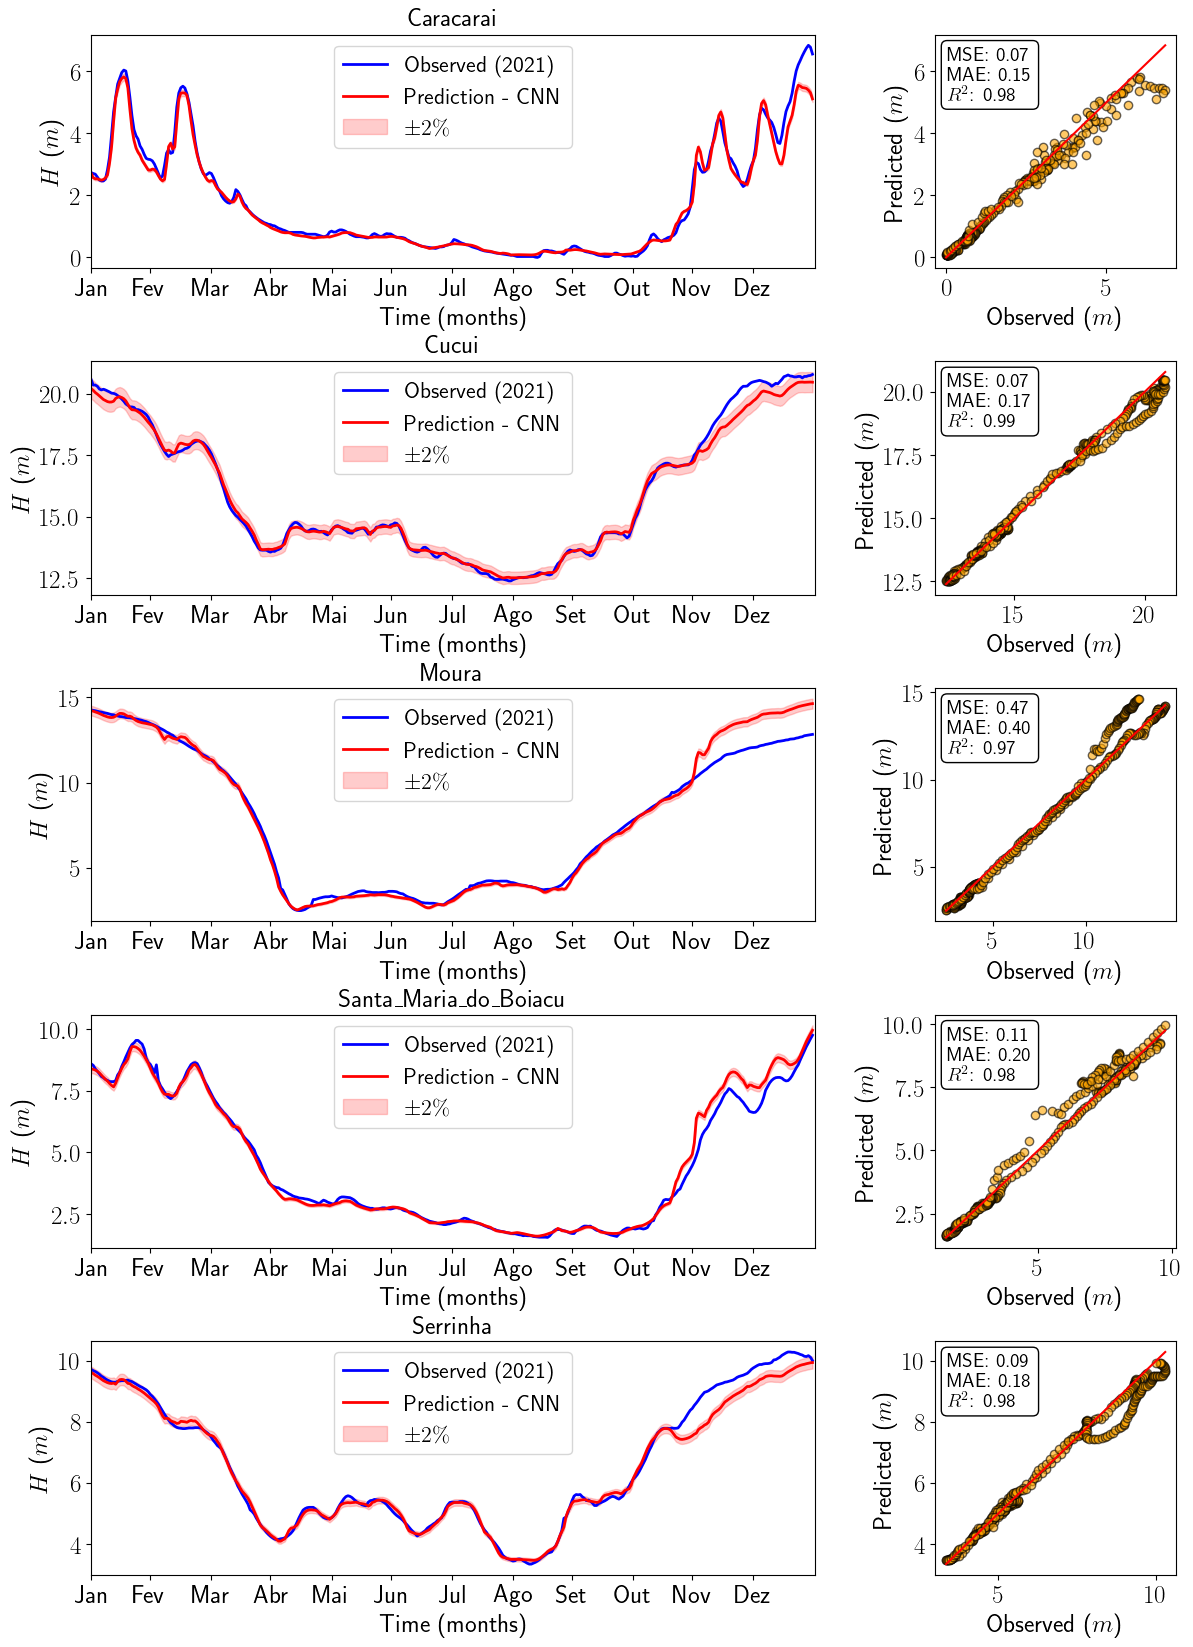

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16

# Número de estações
station_list = list(stations.keys())
n_stations = len(station_list)

fig, axs = plt.subplots(
    n_stations, 2,
    figsize=(14, n_stations * 4),
    gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.25, 'hspace': 0.4}
)

months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# Pré-calcular TODAS as previsões (modelo global gera 5 saídas)
X_inputs = {f"input_{s}": station_data[s][0] for s in stations}
all_preds = model.predict(X_inputs)

# Mapa estação → índice da saída
station_index = {st: i for i, st in enumerate(station_list)}

for i, station in enumerate(station_list):

    X_test, Y_test, scaler_y = station_data[station]

    # pegar a saída correta desta estação
    preds_scaled = all_preds[station_index[station]]

    preds = scaler_y.inverse_transform(preds_scaled)
    Y_real = scaler_y.inverse_transform(Y_test)

    # métricas
    mse  = mean_squared_error(Y_real, preds)
    mae  = mean_absolute_error(Y_real, preds)
    rmse = np.sqrt(mse)
    r2   = r2_score(Y_real, preds)

    # tamanho correto da série
    n_points = len(preds)
    x_axis = np.arange(n_points)

    # faixa ±2%
    lower = preds.flatten() * 0.98
    upper = preds.flatten() * 1.02

    # ---- GRÁFICO DA CURVA (COLUNA 0) ----
    axs[i, 0].plot(x_axis, Y_real.flatten(), label="Observed (2021)", color='blue', linewidth=2)
    axs[i, 0].plot(x_axis, preds.flatten(), label="Prediction - CNN", color='red', linewidth=2)
    axs[i, 0].fill_between(x_axis, lower, upper, color='red', alpha=0.2, label="$\pm 2\%$")

    axs[i, 0].set_title(station)
    axs[i, 0].set_xlabel("Time (months)")
    axs[i, 0].set_ylabel("$H$ ($m$)")

    # Ajuste dos ticks do eixo X baseado no tamanho da série
    axs[i, 0].set_xticks([int(j * (n_points / 12)) for j in range(12)])
    axs[i, 0].set_xticklabels(months)

    axs[i, 0].set_xlim(0, n_points)
    axs[i, 0].legend()

    # ---- GRÁFICO DE DISPERSÃO (COLUNA 1) ----
    axs[i, 1].scatter(Y_real, preds, alpha=0.6, edgecolor='k', facecolor='orange')
    axs[i, 1].plot([Y_real.min(), Y_real.max()],
                   [Y_real.min(), Y_real.max()],
                   color='red', linestyle='-')

    axs[i, 1].set_xlabel("Observed ($m$)")
    axs[i, 1].set_ylabel("Predicted ($m$)")

    # Caixa de métricas
    textstr = f"MSE: {mse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}"
    axs[i, 1].text(0.05, 0.95, textstr,
                   transform=axs[i, 1].transAxes,
                   fontsize=14, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"))

# Salvar
plt.tight_layout()
plt.savefig("prediction_seca_ranges.pdf", format="pdf", bbox_inches="tight")
plt.show()
